In [1]:
# from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
import numpy as np

# from matplotlib.mlab import bivariate_normal

import cartopy.crs as ccrs
import xarray as xr

import math

import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib import ticker
import matplotlib.gridspec as gridspec
from matplotlib.ticker import EngFormatter, StrMethodFormatter

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

from IPython.display import Image

from tqdm import tqdm
import os 

In [2]:
Lats_edge = np.arange(-90,91,6)
Lons_edge = np.arange(-180,181,10)
Levs_edge = np.arange(75,450,50)

Lats_mid = np.arange(-87,90,6)
Lons_mid = np.arange(-175,180,10)
Levs_mid = np.arange(100,450,50)


N_lat = len(Lats_mid)
N_lon = len(Lons_mid)
N_lev = len(Levs_mid) 

Lats_edge, Lons_edge, Levs_edge, Lats_mid, Lons_mid, Levs_mid, N_lat, N_lon, Lons_edge[-1]

(array([-90, -84, -78, -72, -66, -60, -54, -48, -42, -36, -30, -24, -18,
        -12,  -6,   0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,
         66,  72,  78,  84,  90]),
 array([-180, -170, -160, -150, -140, -130, -120, -110, -100,  -90,  -80,
         -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,   10,   20,   30,
          40,   50,   60,   70,   80,   90,  100,  110,  120,  130,  140,
         150,  160,  170,  180]),
 array([ 75, 125, 175, 225, 275, 325, 375, 425]),
 array([-87, -81, -75, -69, -63, -57, -51, -45, -39, -33, -27, -21, -15,
         -9,  -3,   3,   9,  15,  21,  27,  33,  39,  45,  51,  57,  63,
         69,  75,  81,  87]),
 array([-175, -165, -155, -145, -135, -125, -115, -105,  -95,  -85,  -75,
         -65,  -55,  -45,  -35,  -25,  -15,   -5,    5,   15,   25,   35,
          45,   55,   65,   75,   85,   95,  105,  115,  125,  135,  145,
         155,  165,  175]),
 array([100, 150, 200, 250, 300, 350, 400]),
 30,
 36,
 180)

In [3]:
# calculate the area of lon-lat grid [km^2]
def Area_Lat_Weghted(lat1, lat2, d_lon):
    # A = π R² (sin φ1 − sin φ2) (θ1 − θ2)/180.
    Re = 6378 # km
    Area = math.pi * Re**2 * abs(np.sin(np.deg2rad(lat1))-np.sin(np.deg2rad(lat2))) * d_lon/180
    return Area

In [4]:
Grid_area = np.zeros((N_lat, N_lon))

for iy in range(N_lat):
    Grid_area[iy,:] = Area_Lat_Weghted( Lats_edge[iy], Lats_edge[iy+1], abs(Lons_mid[1]-Lons_mid[0]) )

In [5]:
Grid_area

array([[ 38893.47256424,  38893.47256424,  38893.47256424, ...,
         38893.47256424,  38893.47256424,  38893.47256424],
       [116254.29266832, 116254.29266832, 116254.29266832, ...,
        116254.29266832, 116254.29266832, 116254.29266832],
       [192341.40641415, 192341.40641415, 192341.40641415, ...,
        192341.40641415, 192341.40641415, 192341.40641415],
       ...,
       [192341.40641415, 192341.40641415, 192341.40641415, ...,
        192341.40641415, 192341.40641415, 192341.40641415],
       [116254.29266832, 116254.29266832, 116254.29266832, ...,
        116254.29266832, 116254.29266832, 116254.29266832],
       [ 38893.47256424,  38893.47256424,  38893.47256424, ...,
         38893.47256424,  38893.47256424,  38893.47256424]])

In [6]:

Total_Mon = 20*12
Sink_num = np.zeros((N_lat, N_lon, N_lev, Total_Mon))

File = open('/n/home12/hongwei/Paper_3_QBO/Sink_locations/Num_Sinks_Within_15deg_19km.txt', 'r')

Lines = File.readlines()

Months = []
Lons = []
Lats = []
Sink0 = []
Sink1 = []
Sink2 = []
Sink3 = []
Sink4 = []
Sink5 = []
Sink6 = []

for line in Lines:
    a = line.split(',')
    Months.append(float(a[0]))
    Lons.append(float(a[1]))
    Lats.append(float(a[2]))
    
    Sink0.append(float(a[3]))
    Sink1.append(float(a[4]))
    Sink2.append(float(a[5]))
    Sink3.append(float(a[6]))
    Sink4.append(float(a[7]))
    Sink5.append(float(a[8]))
    Sink6.append(float(a[9]))
    
    
i = 0
for i_MON in range(Total_Mon):
    for ix in range(N_lon):
        for iy in range(N_lat):
            Sink_num[iy, ix, :, i_MON]=np.array([Sink0[i],Sink1[i],Sink2[i],Sink3[i],Sink4[i],Sink5[i],Sink6[i]])
            i = i+1

Sink_num.shape


(30, 36, 7, 240)

In [7]:
np.sum(Sink_num)/(10*(360/3))/6, N_lat

(44.0, 30)

## Figure 3: number flux from stratosphere from troposphere

In [8]:
#  get 2005.1 - 2009.12

# 19 km
Sink_num_steady = np.sum(Sink_num[:,:,:,5*12:10*12],axis=2)
Sink_num_steady.shape

(30, 36, 60)

In [9]:
iy_polar = list(np.arange(0,5,1))+list(np.arange(25,30,1))
iy_midlat = list(np.arange(5,10,1))+list(np.arange(20,25,1))
iy_tropic = list(np.arange(10,20,1))

Lats_mid[iy_polar], Lats_mid[iy_midlat], Lats_mid[iy_tropic]

(array([-87, -81, -75, -69, -63,  63,  69,  75,  81,  87]),
 array([-57, -51, -45, -39, -33,  33,  39,  45,  51,  57]),
 array([-27, -21, -15,  -9,  -3,   3,   9,  15,  21,  27]))

In [10]:
# sum: particles per month for all injection locations

Num_month_tropic = np.sum(Sink_num_steady[iy_tropic,:,:], axis=(0,1))
Num_month_midlat = np.sum(Sink_num_steady[iy_midlat,:,:], axis=(0,1))
Num_month_polar = np.sum(Sink_num_steady[iy_polar,:,:], axis=(0,1))

Num_tropic_MonMean = np.mean(Num_month_tropic)
Num_midlat_MonMean = np.mean(Num_month_midlat)
Num_polar_MonMean = np.mean(Num_month_polar)

print(Num_tropic_MonMean, Num_midlat_MonMean, Num_polar_MonMean)

total = Num_tropic_MonMean+Num_midlat_MonMean+Num_polar_MonMean

print("The percentage of particle number sink in tropical, mid-lat, and polar are:")
print(f"{ Num_tropic_MonMean/total:.2f}, { Num_midlat_MonMean/total:.2f}, { Num_polar_MonMean/total:.2f}")

Num_tropic_MonMean+Num_midlat_MonMean+Num_polar_MonMean, 21*24*10

521.55 1762.0333333333333 342.68333333333334
The percentage of particle number sink in tropical, mid-lat, and polar are:
0.20, 0.67, 0.13


(2626.2666666666664, 5040)

## Discussion: for injection only at equator

In [11]:
iy_tropic, Lats_mid[iy_tropic]

([10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 array([-27, -21, -15,  -9,  -3,   3,   9,  15,  21,  27]))

In [12]:
iy_equator=14
Lats_mid[iy_equator]

-3

# QBO

In [13]:
import pywt
import scipy.signal as Signal
# from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image

[-87 -81 -75 -69 -63]
(240,)


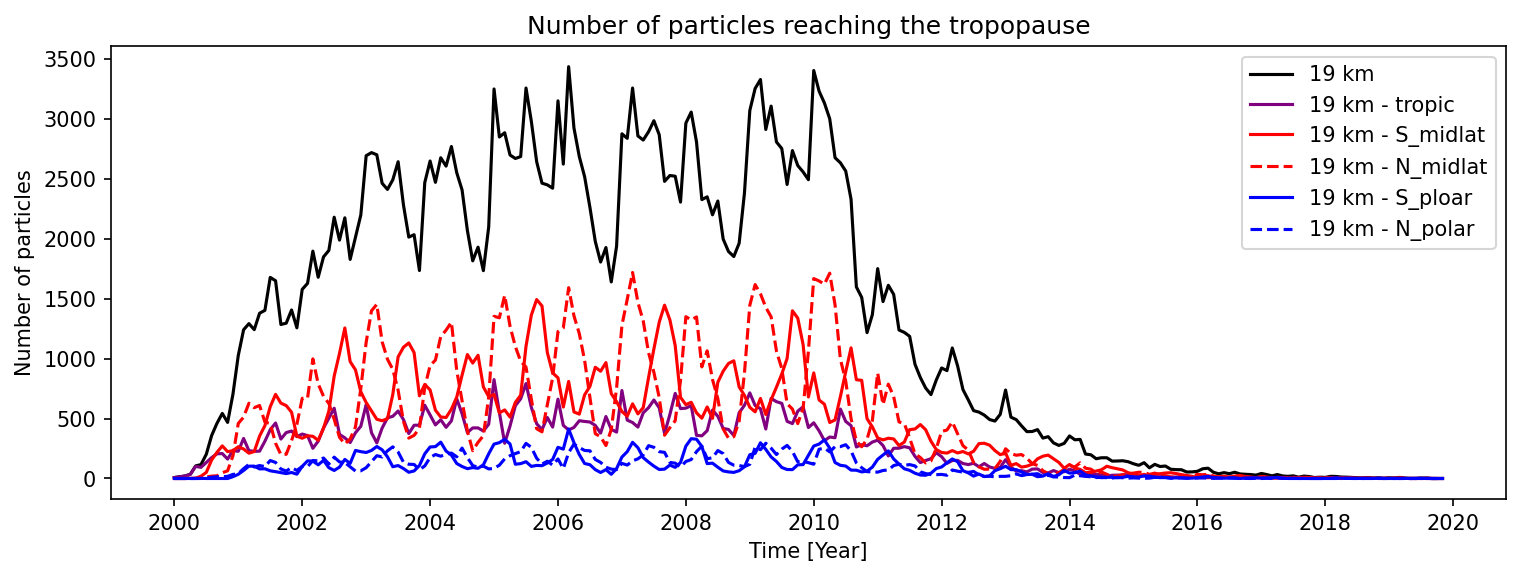

In [14]:
#------------------------------------------------------------------
# plot the time series of the total particle number
#------------------------------------------------------------------

iy_S_polar  = list(np.arange(0,5,1))
iy_S_midlat = list(np.arange(5,10,1))
iy_tropic   = list(np.arange(10,20,1))
iy_N_midlat = list(np.arange(20,25,1))
iy_N_polar  = list(np.arange(25,30,1))
print(Lats_mid[iy_S_polar])

Heights = [20]

sink_num_month = np.sum( Sink_num, axis=(0,1,2) )
sink_num_month_tropic   = np.sum( Sink_num[iy_tropic,:,:,:], axis=(0,1,2) )
sink_num_month_S_midlat = np.sum( Sink_num[iy_S_midlat,:,:,:], axis=(0,1,2) )
sink_num_month_N_midlat = np.sum( Sink_num[iy_N_midlat,:,:,:], axis=(0,1,2) )
sink_num_month_S_polar  = np.sum( Sink_num[iy_S_polar,:,:,:], axis=(0,1,2) )
sink_num_month_N_polar  = np.sum( Sink_num[iy_N_polar,:,:,:], axis=(0,1,2) )

print(sink_num_month.shape)

#
fig = plt.figure(figsize=(12,4), dpi=150)

imon_begin = 0
imon_end = -1

plt.plot(sink_num_month[imon_begin:imon_end], 'k', label=f"19 km")
plt.plot(sink_num_month_tropic[imon_begin:imon_end], 'purple', label=f"19 km - tropic")
plt.plot(sink_num_month_S_midlat[imon_begin:imon_end], 'r-', label=f"19 km - S_midlat")
plt.plot(sink_num_month_N_midlat[imon_begin:imon_end], 'r--', label=f"19 km - N_midlat")
plt.plot(sink_num_month_S_polar[imon_begin:imon_end], 'b-', label=f"19 km - S_ploar")
plt.plot(sink_num_month_N_polar[imon_begin:imon_end], 'b--', label=f"19 km - N_polar")

# plt.xscale("log")
# plt.yscale("log")

plt.xlabel("Time [Year]")
plt.ylabel("Number of particles")
plt.title("Number of particles reaching the tropopause")

plt.xticks(np.arange(0,20*12+1,2*12), 
       ['2000', '2002', '2004', '2006', '2008', '2010', \
        '2012', '2014', '2016', '2018', '2020'], rotation=0) 

plt.legend();

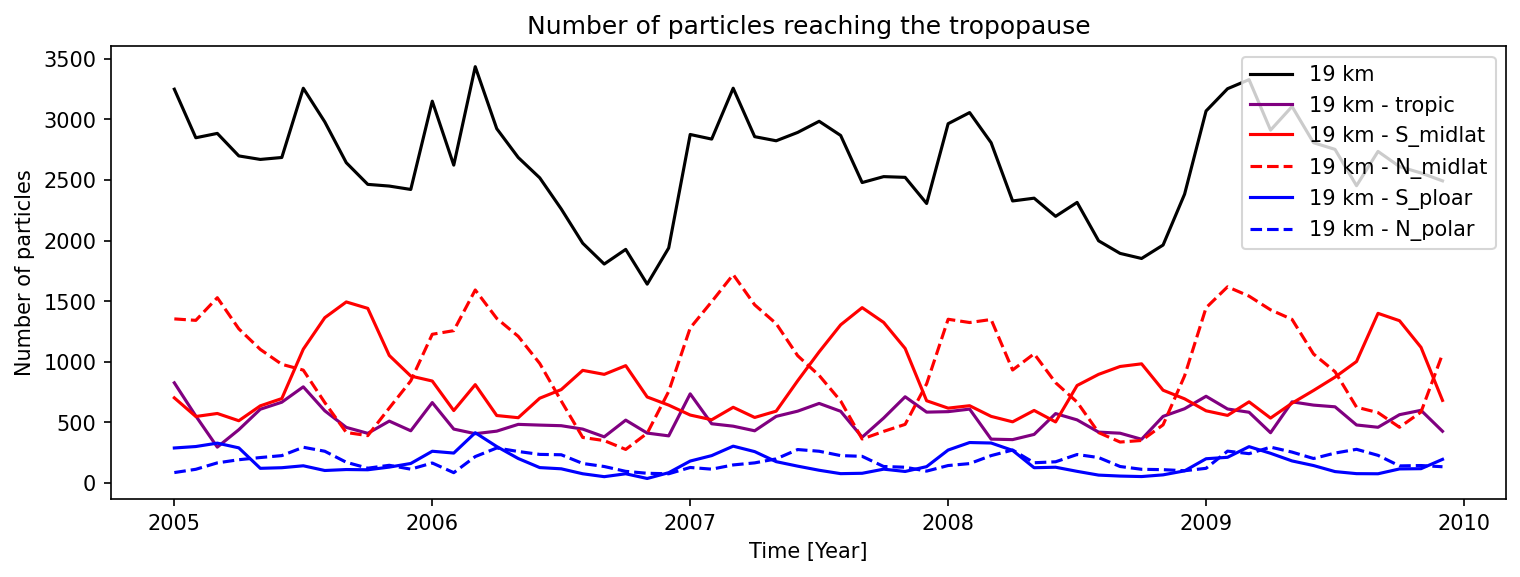

In [15]:
#
fig = plt.figure(figsize=(12,4), dpi=150)

imon_begin = 5*12
imon_end = 10*12

sink_num_month_5yr = sink_num_month[imon_begin:imon_end]
sink_num_month_tropic_5yr = sink_num_month_tropic[imon_begin:imon_end]
sink_num_month_S_midlat_5yr = sink_num_month_S_midlat[imon_begin:imon_end]
sink_num_month_N_midlat_5yr = sink_num_month_N_midlat[imon_begin:imon_end]
sink_num_month_S_polar_5yr = sink_num_month_S_polar[imon_begin:imon_end]
sink_num_month_N_polar_5yr = sink_num_month_N_polar[imon_begin:imon_end]

plt.plot(sink_num_month[imon_begin:imon_end], 'k', label=f"19 km")
plt.plot(sink_num_month_tropic[imon_begin:imon_end], 'purple', label=f"19 km - tropic")
plt.plot(sink_num_month_S_midlat[imon_begin:imon_end], 'r-', label=f"19 km - S_midlat")
plt.plot(sink_num_month_N_midlat[imon_begin:imon_end], 'r--', label=f"19 km - N_midlat")
plt.plot(sink_num_month_S_polar[imon_begin:imon_end], 'b-', label=f"19 km - S_ploar")
plt.plot(sink_num_month_N_polar[imon_begin:imon_end], 'b--', label=f"19 km - N_polar")

# plt.xscale("log")
# plt.yscale("log")

plt.xlabel("Time [Year]")
plt.ylabel("Number of particles")
plt.title("Number of particles reaching the tropopause")

plt.xticks(np.arange(0,5*12+1,12), ['2005', '2006', '2007', '2008', '2009', '2010'], rotation=0) 

plt.legend();

In [16]:
  
##### detrend
sink_num_month_5yr_detrend = Signal.detrend(sink_num_month_5yr)

# deseasonal
N_total = len(sink_num_month_5yr_detrend)
sink_num_month_5yr_detrend_deseason = 0.0*sink_num_month_5yr_detrend

for idx in range(N_total):
    idx2 = idx % 12
    sink_num_month_5yr_detrend_deseason[idx] = sink_num_month_5yr_detrend[idx] \
                                         - np.mean(sink_num_month_5yr_detrend[idx2:N_total:12])
    

##### detrand
sink_num_month_tropic_5yr_detrend = Signal.detrend(sink_num_month_tropic_5yr)

# deseasonal
N_total = len(sink_num_month_tropic_5yr_detrend)
sink_num_month_tropic_5yr_detrend_deseason = 0.0*sink_num_month_tropic_5yr_detrend

for idx in range(N_total):
    idx2 = idx % 12
    sink_num_month_tropic_5yr_detrend_deseason[idx] = sink_num_month_tropic_5yr_detrend[idx] \
                                         - np.mean(sink_num_month_tropic_5yr_detrend[idx2:N_total:12])
    
    

##### detrand
sink_num_month_S_midlat_5yr_detrend = Signal.detrend(sink_num_month_S_midlat_5yr)

# deseasonal
N_total = len(sink_num_month_S_midlat_5yr_detrend)
sink_num_month_S_midlat_5yr_detrend_deseason = 0.0*sink_num_month_S_midlat_5yr_detrend

for idx in range(N_total):
    idx2 = idx % 12
    sink_num_month_S_midlat_5yr_detrend_deseason[idx] = sink_num_month_S_midlat_5yr_detrend[idx] \
                                         - np.mean(sink_num_month_S_midlat_5yr_detrend[idx2:N_total:12])
    

# detrand
sink_num_month_N_midlat_5yr_detrend = Signal.detrend(sink_num_month_N_midlat_5yr)

# deseasonal
N_total = len(sink_num_month_N_midlat_5yr_detrend)
sink_num_month_N_midlat_5yr_detrend_deseason = 0.0*sink_num_month_N_midlat_5yr_detrend

for idx in range(N_total):
    idx2 = idx % 12
    sink_num_month_N_midlat_5yr_detrend_deseason[idx] = sink_num_month_N_midlat_5yr_detrend[idx] \
                                         - np.mean(sink_num_month_N_midlat_5yr_detrend[idx2:N_total:12])
    
    
    
##### detrand
sink_num_month_S_polar_5yr_detrend = Signal.detrend(sink_num_month_S_polar_5yr)

# deseasonal
N_total = len(sink_num_month_S_polar_5yr_detrend)
sink_num_month_S_polar_5yr_detrend_deseason = 0.0*sink_num_month_S_polar_5yr_detrend

for idx in range(N_total):
    idx2 = idx % 12
    sink_num_month_S_polar_5yr_detrend_deseason[idx] = sink_num_month_S_polar_5yr_detrend[idx] \
                                         - np.mean(sink_num_month_S_polar_5yr_detrend[idx2:N_total:12])
    

# detrand
sink_num_month_N_polar_5yr_detrend = Signal.detrend(sink_num_month_N_polar_5yr)
print(sink_num_month_N_polar_5yr_detrend.shape)

# deseasonal
N_total = len(sink_num_month_N_polar_5yr_detrend)
sink_num_month_N_polar_5yr_detrend_deseason = 0.0*sink_num_month_N_polar_5yr_detrend

for idx in range(N_total):
    idx2 = idx % 12
    sink_num_month_N_polar_5yr_detrend_deseason[idx] = sink_num_month_N_polar_5yr_detrend[idx] \
                                         - np.mean(sink_num_month_N_polar_5yr_detrend[idx2:N_total:12])
    

(60,)


In [17]:
# QBO for singapore obs data:
# https://acd-ext.gsfc.nasa.gov/Data_services/met/qbo/QBO_Singapore_Uvals_GSFC.txt
df = pd.read_fwf('../QBO_Singapore_index.txt', sep=" ")

# get 2005.1 - 2009.12
idx1 = (2005-1979)*12
df2 = df.iloc[idx1:idx1+5*12]

df2.head()

Month  Year   100    90    80    70     50     40     30     20     15  \
312      1  2005 -2.53 -1.13 -2.62  0.50   5.38   9.65  -1.64 -28.39 -28.37   
313      2  2005  2.60  0.68 -0.35  1.95   9.88  11.87   1.67 -29.76 -30.79   
314      3  2005 -8.15 -4.47  1.75  7.71  14.51  15.05  -1.02 -29.72 -33.98   
315      4  2005 -0.50 -0.18  0.88  2.79   8.16   5.73 -18.22 -32.82 -34.12   
316      5  2005 -9.23 -8.89 -0.62  6.73   8.36  -8.09 -26.69 -33.13 -34.52   

        10  
312 -25.98  
313 -31.41  
314 -34.78  
315 -35.27  
316 -37.37

[1, 2, 3, 4, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 42, 43, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[0, 1, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 39, 40, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
[[1.         0.80611027]
 [0.80611027 1.        ]]
[[ 1.         -0.83674352]
 [-0.83674352  1.        ]]
[[1.         0.80201821]
 [0.80201821 1.        ]]
[[ 1.         -0.72596849]
 [-0.72596849  1.        ]]
----------------------------------------------------
[[1.         0.41418681]
 [0.41418681 1.        ]]
[[1.        0.3576153]
 [0.3576153 1.       ]]
[[1.         0.17291592]
 [0.17291592 1.        ]]
[[1.         0.04028954]
 [0.04028954 1.        ]]
[[1.         0.04028954]
 [0.04028954 1.        ]]


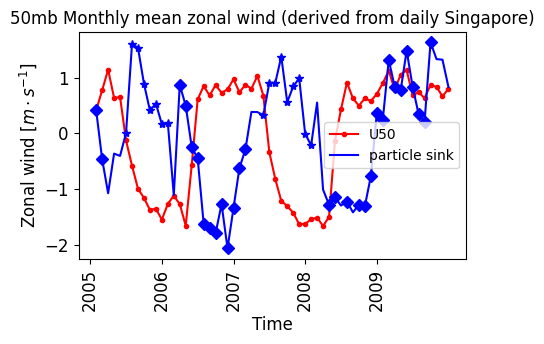

In [18]:
U50 = df2['50']
U_shear = df2['20'] - df2['70']


month = np.arange(1,len(U50)+1,1)

fig = plt.figure(figsize=(5,3),dpi=100)

data50 = (U50 - np.mean(U50))/np.std(U50)
data_shear = (U_shear - np.mean(U_shear))/np.std(U_shear)

data2 = (sink_num_month_S_midlat_5yr_detrend_deseason - np.mean(sink_num_month_S_midlat_5yr_detrend_deseason))/np.std(sink_num_month_S_midlat_5yr_detrend_deseason)
data2 = (sink_num_month_N_midlat_5yr_detrend_deseason - np.mean(sink_num_month_N_midlat_5yr_detrend_deseason))/np.std(sink_num_month_N_midlat_5yr_detrend_deseason)
data2 = (sink_num_month_5yr_detrend_deseason - np.mean(sink_num_month_5yr_detrend_deseason))/np.std(sink_num_month_5yr_detrend_deseason)

res1 = [idx for idx, val in enumerate(data50) if val > 0.6]
res2 = [idx for idx, val in enumerate(data50) if val < -1.0]

res11 = [x-3 for x in res1 if x>=3]
res22 = [x-3 for x in res2 if x>=3]

print(res1)
print(res11)
data50 = data50.values

QBO_data = data50
plt.plot(month, QBO_data, 'r.-', label='U50')
# plt.plot(month[res1], QBO_data[res1], 'rD')
# plt.plot(month[res2], QBO_data[res2], 'r*')

plt.plot(month, data2, 'b-', label='particle sink')
plt.plot(month[res11], data2[res11], 'bD')
plt.plot(month[res22], data2[res22], 'b*')

tick_locs = np.arange(0,len(month),12)
tick_lbls = np.arange(2005,2010,1)
plt.xticks(tick_locs, tick_lbls, rotation='vertical', fontsize=12)
plt.yticks(fontsize=12)


plt.title('50mb Monthly mean zonal wind (derived from daily Singapore)', fontsize=12)
plt.ylabel('Zonal wind [$m \cdot s^{-1}$]', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.legend();

D_mon = 7
print(np.corrcoef(U50[0:60-D_mon], sink_num_month_5yr_detrend_deseason[D_mon:60]))
D_mon = 19
print(np.corrcoef(U50[0:60-D_mon], sink_num_month_5yr_detrend_deseason[D_mon:60]))


D_mon = 16
print(np.corrcoef(U_shear[0:60-D_mon], sink_num_month_5yr_detrend_deseason[D_mon:60]))
D_mon = 4
print(np.corrcoef(U_shear[0:60-D_mon], sink_num_month_5yr_detrend_deseason[D_mon:60]))

print('----------------------------------------------------')
D_mon = 7
print(np.corrcoef(U50[0:60-D_mon], sink_num_month_tropic_5yr[D_mon:60]))
D_mon = 7
print(np.corrcoef(U50[0:60-D_mon], sink_num_month_S_midlat_5yr[D_mon:60]))
D_mon = 7
print(np.corrcoef(U50[0:60-D_mon], sink_num_month_N_midlat_5yr[D_mon:60]))
print(np.corrcoef(U50[0:60-D_mon], sink_num_month_S_polar_5yr[D_mon:60]))
print(np.corrcoef(U50[0:60-D_mon], sink_num_month_S_polar_5yr[D_mon:60]))


In [19]:
D_mon = 4
print(np.corrcoef(U50[0:60-D_mon], sink_num_month_5yr_detrend_deseason[D_mon:60]))

[[1.         0.46845146]
 [0.46845146 1.        ]]


In [20]:
D_mon = 7
print(np.corrcoef(U50[0:60-D_mon], sink_num_month_tropic_5yr_detrend_deseason[D_mon:60]))

[[1.         0.55969369]
 [0.55969369 1.        ]]


In [21]:
D_mon = 4
print(np.corrcoef(U50[D_mon:60], sink_num_month_S_midlat_5yr_detrend_deseason[0:60-D_mon]))
print(np.corrcoef(U50[D_mon:60], sink_num_month_N_midlat_5yr_detrend_deseason[0:60-D_mon]))
D_mon = 6
print(np.corrcoef(U50[0:60-D_mon], sink_num_month_N_midlat_5yr_detrend_deseason[D_mon:60]))

[[ 1.         -0.67865727]
 [-0.67865727  1.        ]]
[[ 1.         -0.12031004]
 [-0.12031004  1.        ]]
[[1.        0.6751659]
 [0.6751659 1.       ]]


In [22]:
D_mon = 11
print(np.corrcoef(U50[0:60-D_mon], sink_num_month_S_polar_5yr_detrend_deseason[D_mon:60]))
D_mon = 11
print(np.corrcoef(U50[0:60-D_mon], sink_num_month_N_polar_5yr_detrend_deseason[D_mon:60]))

[[1.         0.65473862]
 [0.65473862 1.        ]]
[[1.         0.36477725]
 [0.36477725 1.        ]]


## Figure 4: particle numbers at different sink location

In [23]:
# Sink_num = np.zeros((N_lat, N_lon, N_lev, Total_Mon))

i_mon1 = 5*12
i_mon2 = 10*12

Sink_num_5yr = np.sum(Sink_num[:,:,:,5*12:10*12],axis=2)


In [24]:
# !pip show matplotlib

In [25]:
# !pip install --upgrade cartopy
# !pip install --upgrade matplotlib

(30, 36)


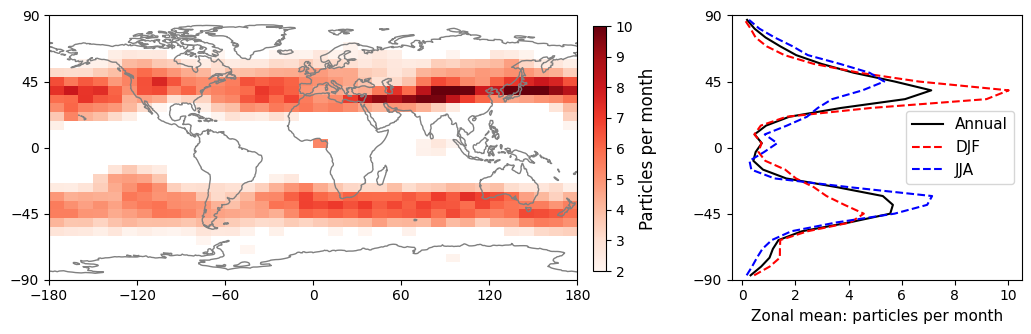

In [26]:
from copy import copy

iz = 2
i_mon1 = 0
i_mon2 = Total_Mon

fig = plt.figure(figsize=(13,3.5), dpi=100)
gs = gridspec.GridSpec(1, 10, figure=fig)
projection = crs.PlateCarree()

Num_min = 2
Num_max = 10
extent = [-180 , 180 , 90 , -90]

###
ax1 = fig.add_subplot(gs[0, 0:6], projection=projection)

ax1.set_global()
ax1.set_extent([-180, 180, 90, -90], crs=projection) ## Important
ax1.add_feature(cfeature.COASTLINE, edgecolor="gray")

palette = copy(plt.get_cmap('Reds'))
palette.set_under('white', 1.0)

data = np.mean( Sink_num_5yr[:,:,:], axis=2 )
ax1_pixel = plt.imshow(data, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap=palette, interpolation='nearest')

cax = fig.add_axes([0.57, 0.15, 0.01, 0.7])    
cb1 = plt.colorbar(ax1_pixel, cax=cax, ax=ax1, orientation="vertical")
# cb1 = plt.colorbar(ax1_pixel, ax=ax1, orientation="horizontal")

cb1.set_label('Particles per month', fontsize=12);

ax1.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=projection)

# ax1.set_title("Number of particles sinking in the tropopause");

print(data.shape)


###
ax2 = fig.add_subplot(gs[0, 7:10])

data_all = np.mean( Sink_num_5yr[:,:,:], axis=(1,2) )

data_DJF = ( np.mean(Sink_num_5yr[:,:,11:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,0:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,1:-1:12], axis=(1,2)) )/3

data_MAM = ( np.mean(Sink_num_5yr[:,:,2:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,3:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,4:-1:12], axis=(1,2)) )/3

data_JJA = ( np.mean(Sink_num_5yr[:,:,5:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,6:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,7:-1:12], axis=(1,2)) )/3

data_SON = ( np.mean(Sink_num_5yr[:,:,8:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,9:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,10:-1:12], axis=(1,2)) )/3



ax2.plot(data_all[:], Lats_mid, 'k-',  label="Annual")
ax2.plot(data_DJF[:], Lats_mid, 'r--', label="DJF")
# ax2.plot(data_MAM[:], Lats_mid, 'b--', label="MAM")
ax2.plot(data_JJA[:], Lats_mid, 'b--', label="JJA")
# ax2.plot(data_SON[:], Lats_mid, 'y--', label="SON")

ax2.set_ylim(-90,90)
ax2.set_yticks((-90,-45,0,45,90))
# ax2.set_yticklabels(-90,-45,0,45,90)

ax2.set_xlabel("Zonal mean: particles per month", fontsize=11);
# ax2.set_title("Zonal mean of sinks");

ax2.legend(fontsize=11, loc='center right');
# plt.tight_layout()

(30, 36)
Copy the colorbar from the above figure!


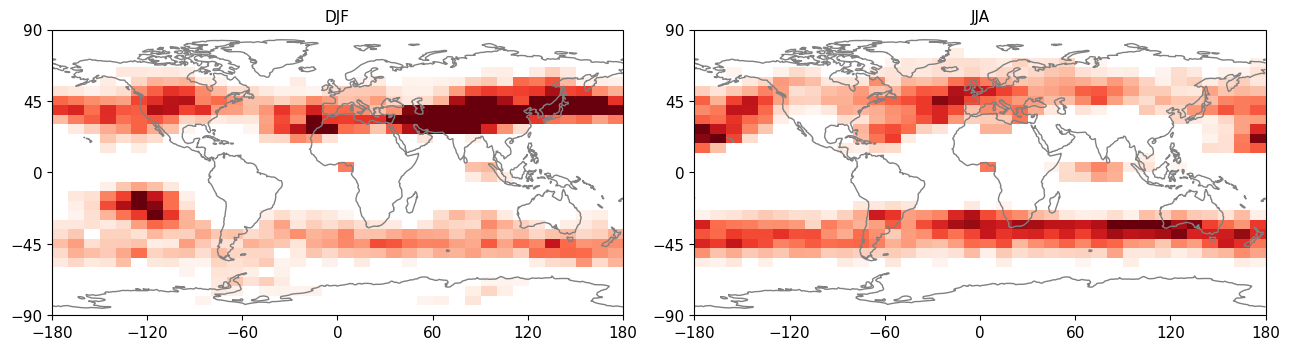

In [27]:
fig = plt.figure(figsize=(13,3.5), dpi=100)
gs = gridspec.GridSpec(1, 11, figure=fig)
projection = crs.PlateCarree()


extent = [-180 , 180 , 90 , -90]

###
ax1 = fig.add_subplot(1,2,1, projection=projection)

ax1.set_global()
ax1.set_extent([-180, 180, 90, -90], crs=projection) ## Important
ax1.add_feature(cfeature.COASTLINE, edgecolor="gray")

data_DJF = ( np.mean(Sink_num_5yr[:,:,11:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,0:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,1:-1:12], axis=(2)) )/3

ax1_pixel = plt.imshow(data_DJF, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap=palette, interpolation='nearest')

# cb1 = plt.colorbar(ax1_pixel, ax=ax1)
# cb1.set_label('[Number of Particles]', fontsize=12);

ax1.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=projection)

ax1.tick_params(labelsize=11)

ax1.set_title("DJF", fontsize=11);

print(data.shape)



###
ax3 = fig.add_subplot(1,2,2, projection=projection)

ax3.set_global()
ax3.set_extent([-180, 180, 90, -90], crs=projection) ## Important
ax3.add_feature(cfeature.COASTLINE, edgecolor="gray")

data_JJA = ( np.mean(Sink_num_5yr[:,:,5:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,6:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,7:-1:12], axis=(2)) )/3

ax3_pixel = plt.imshow(data_JJA, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap=palette, interpolation='nearest')

# levels = 
# extent=extent
# ax3_contour = plt.contour(U200_5yr_DJF_mean, colors='k', linestyles='dashed')

# cb3 = plt.colorbar(ax3_pixel, ax=ax3)
# cb3.set_label('[Number of Particles]', fontsize=12);

ax3.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax3.set_yticks(np.linspace(-90, 90, 5), crs=projection)

ax3.tick_params(labelsize=11)

ax3.set_title("JJA", fontsize=11);

plt.tight_layout()


print("Copy the colorbar from the above figure!")

# Sink between QBO E vs. W

In [28]:
Sink_num_5yr.shape

(30, 36, 60)

### QBO West phase:

2005.1-2005.4

2007.1-2007.4

2009.1-2009.4

### QBO East phase:

2006.1-2006.4

2008.1-2008.4


## Important: the time selected for particle number should be 3 month lag!!!

In [29]:

###

time_lag = 7

it_w1 = 0+time_lag
it_w2 = 4+time_lag

it_w3 = 12*2+time_lag
it_w4 = 12*2+4+time_lag

it_w5 = 12*4+time_lag
it_w6 = 12*4+4+time_lag

N_mon_W = it_w6-it_w5 + it_w4-it_w3 + it_w2-it_w1

Sink_num_W = ( np.sum(Sink_num_5yr[:,:,it_w1:it_w2], axis=2) + np.sum(Sink_num_5yr[:,:,it_w3:it_w4], axis=2) + np.sum(Sink_num_5yr[:,:,it_w5:it_w6], axis=2) ) / N_mon_W

###
it_e1 = 12*1+time_lag
it_e2 = 12*1+4+time_lag

it_e3 = 12*3+time_lag
it_e4 = 12*3+4+time_lag

N_mon_E = it_e4-it_e3 + it_e2-it_e1

Sink_num_E = ( np.sum(Sink_num_5yr[:,:,it_e1:it_e2], axis=2) + np.sum(Sink_num_5yr[:,:,it_e3:it_e4], axis=2) ) / N_mon_E

Sink_num_E.shape

(30, 36)

(30, 36)


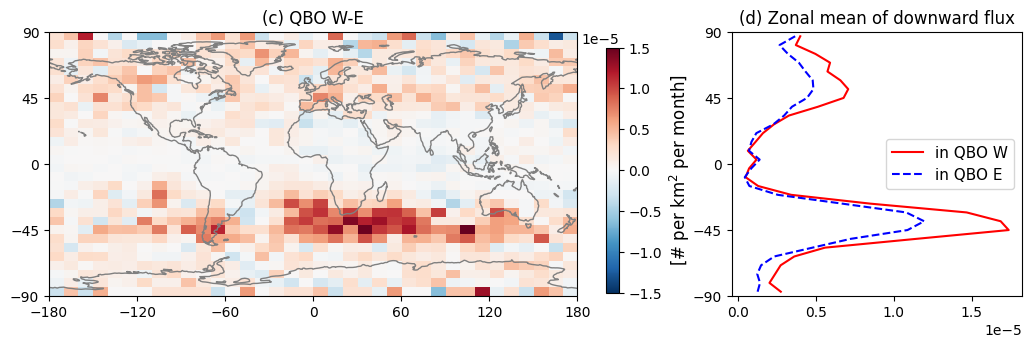

In [30]:
from copy import copy

iz = 2
i_mon1 = 0
i_mon2 = Total_Mon

fig = plt.figure(figsize=(13,3.5), dpi=100)
gs = gridspec.GridSpec(1, 10, figure=fig)
projection = crs.PlateCarree()

Num_min = -1.5e-5 
Num_max = 1.5e-5
# Num_min = -5
# Num_max = 5
extent = [-180 , 180 , 90 , -90]

###
ax1 = fig.add_subplot(gs[0, 0:6], projection=projection)

ax1.set_global()
ax1.set_extent([-180, 180, 90, -90], crs=projection) ## Important
ax1.add_feature(cfeature.COASTLINE, edgecolor="gray")

palette = copy(plt.get_cmap('RdBu_r'))
palette.set_under('white', 1.0)

# /Grid_area[:,:]
data = (Sink_num_W - Sink_num_E)/ Grid_area[:,:]
ax1_pixel = plt.imshow(data, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap=palette, interpolation='nearest')

cax = fig.add_axes([0.58, 0.135, 0.01, 0.7])    
cb1 = plt.colorbar(ax1_pixel, cax=cax, ax=ax1, orientation="vertical")
# cb1 = plt.colorbar(ax1_pixel, ax=ax1, orientation="horizontal")

cb1.set_label('[# per km$^2$ per month]', fontsize=12);

ax1.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=projection)

ax1.set_title("(c) QBO W-E");

print(data.shape)

###
ax2 = fig.add_subplot(gs[0, 7:10])

Sink_num_5yr_tmean = np.mean(Sink_num_5yr[:,:,:], axis=(2))
data_all = np.mean( Sink_num_5yr_tmean[:,:]/ Grid_area[:,:], axis=(1) )
data_W = np.mean( Sink_num_W[:,:]/ Grid_area[:,:], axis=(1) )
data_E = np.mean( Sink_num_E[:,:]/ Grid_area[:,:], axis=(1) )

# ax2.plot(data_all[:], Lats_mid, 'k-',  label="Annual")
ax2.plot(data_W[:], Lats_mid, 'r-', label="in QBO W")
# ax2.plot(data_MAM[:], Lats_mid, 'b--', label="MAM")
ax2.plot(data_E[:], Lats_mid, 'b--', label="in QBO E")
# ax2.plot(data_SON[:], Lats_mid, 'y--', label="SON")

ax2.set_ylim(-90,90)
ax2.set_yticks((-90,-45,0,45,90))
# ax2.set_yticklabels(-90,-45,0,45,90)

# ax2.set_xlabel("Zonal mean of number flux", fontsize=11);
ax2.set_title("(d) Zonal mean of downward flux");

ax2.legend(fontsize=11, loc='center right');
# plt.tight_layout()

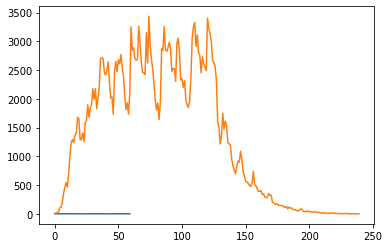

In [31]:
Sink_total = np.mean(Sink_num_5yr[:,:,:],axis=(0,1))

plt.plot(Sink_total)
plt.plot(sink_num_month)

# Double tropopause

In [32]:
ds = xr.open_dataset('/n/home12/hongwei/HONGWEI/Tropopause/ERA5low_wmo_2nd_z_2005-2009_daymean.nc')

time = ds['time']
lon = ds['lon']
lat = ds['lat']

X, Y = np.meshgrid(lon, lat)

Nt = len(time)
Nx = len(lon)
Ny = len(lat)

Double_Tropo = ds['wmo_2nd_z']

In [33]:
DT_freq = Double_Tropo/Double_Tropo

In [34]:
N_yr = 5
N_day = 365
DT_freq_new = np.zeros((N_day, N_yr, Ny, Nx))

for iyr in range(N_yr):
    for iday in range(N_day):
        it = N_day*iyr + iday
        DT_freq_new[iday, iyr, :, :] = DT_freq[it, :, :]

In [35]:
DT_freq_Annal = np.nansum(DT_freq_new, axis=(0,1)) /(N_day*N_yr)*100

DT_freq_DJF = ( np.nansum(DT_freq_new[11*30:12*30,:,:,:], axis=(0,1)) + np.nansum(DT_freq_new[0:2*30,:,:,:], axis=(0,1)) ) /(3*30*N_yr)*100
DT_freq_MAM = np.nansum(DT_freq_new[2*30:5*30,:,:,:], axis=(0,1)) /(3*30*N_yr)*100
DT_freq_JJA = np.nansum(DT_freq_new[5*30:8*30,:,:,:], axis=(0,1)) /(3*30*N_yr)*100
DT_freq_SON = np.nansum(DT_freq_new[8*30:11*30,:,:,:], axis=(0,1)) /(3*30*N_yr)*100

(30, 36)


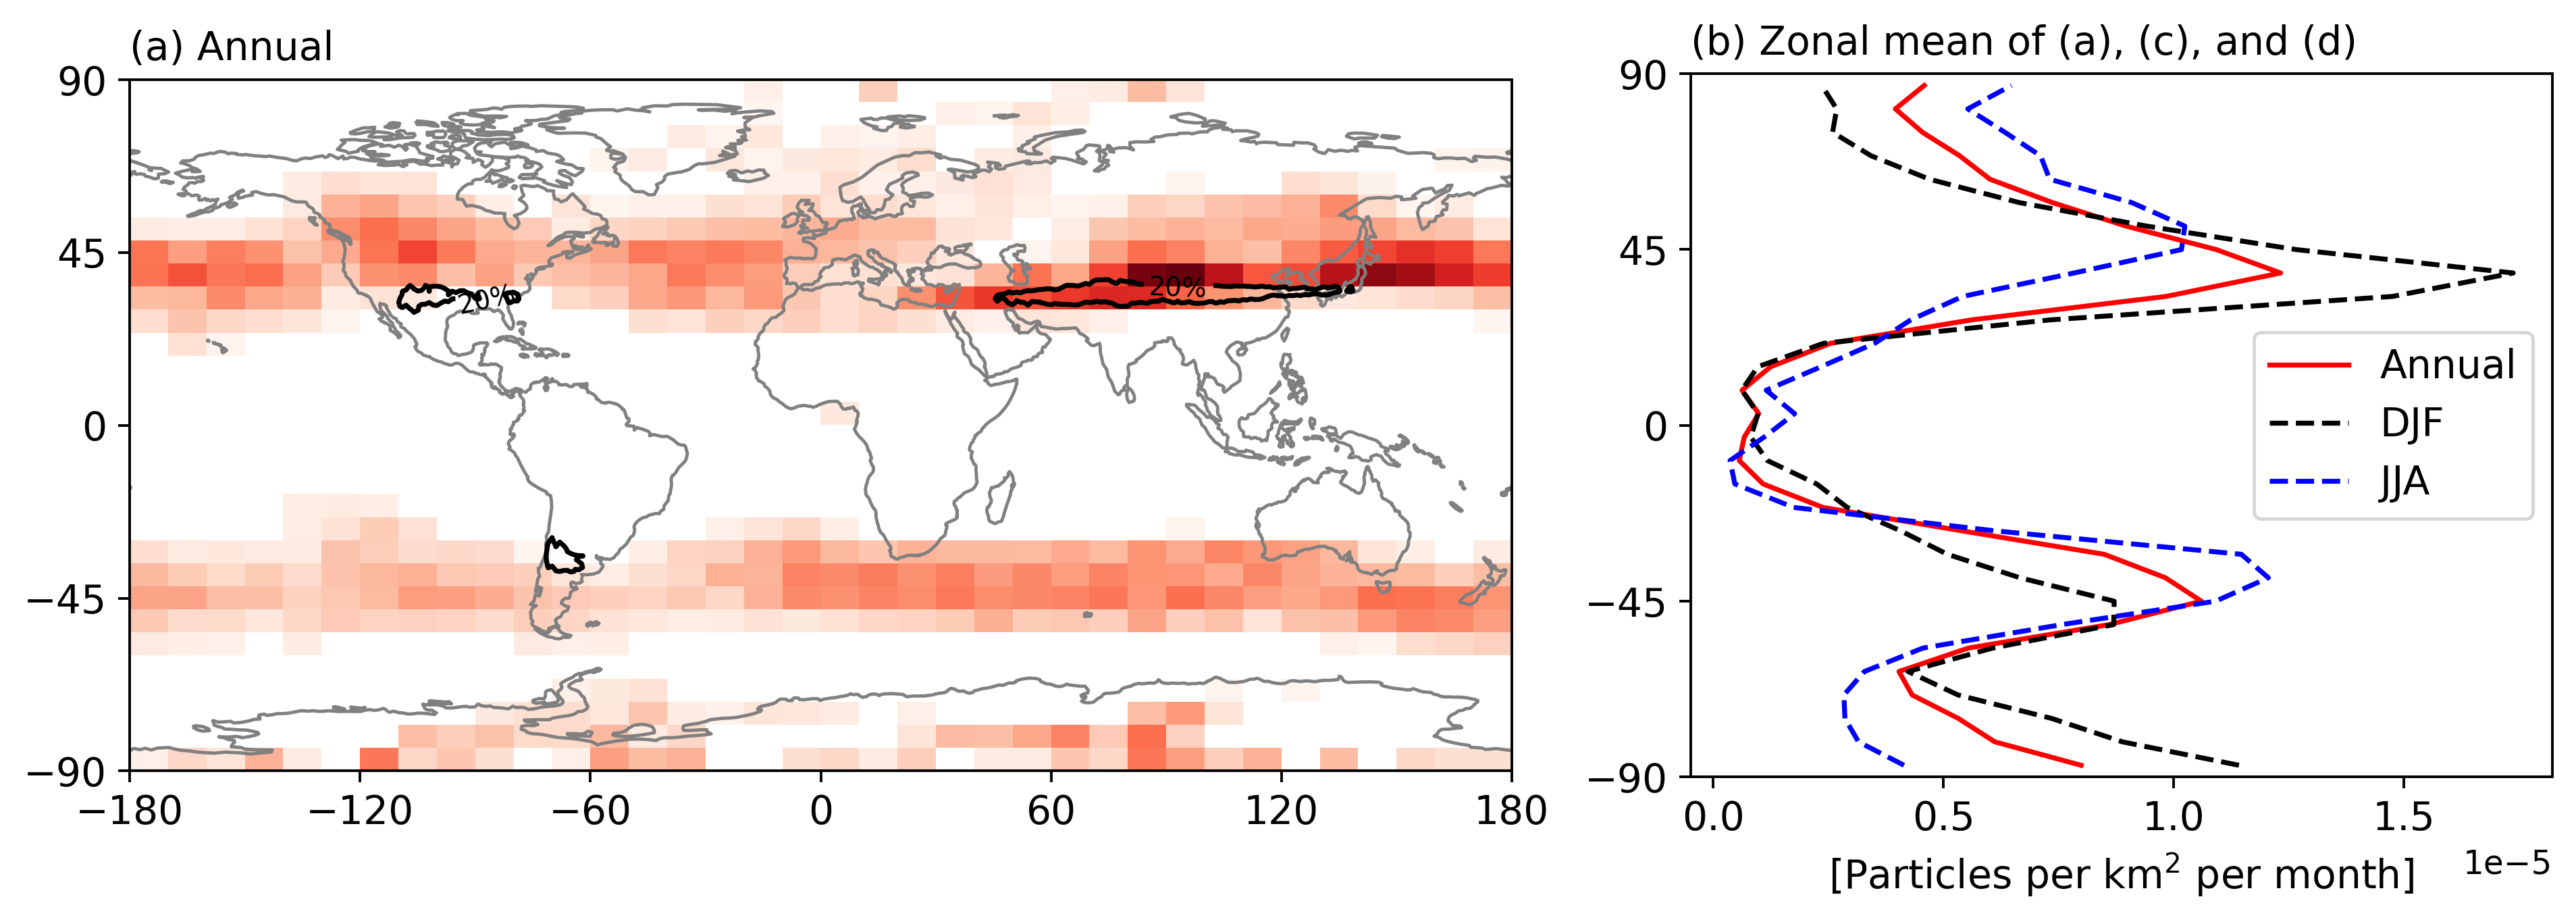

In [53]:
iz = 2
i_mon1 = 0
i_mon2 = Total_Mon

fig = plt.figure(figsize=(11,4), dpi=350)
gs = gridspec.GridSpec(1, 10, figure=fig)
projection = crs.PlateCarree()

Num_min = 6e-6
Num_max = 20e-6
extent = [-180 , 180 , 90 , -90]

###
ax1 = fig.add_subplot(gs[0, 0:6], projection=projection)

ax1.set_global()
ax1.set_extent([-180, 180, 90, -90], crs=projection) ## Important
ax1.add_feature(cfeature.COASTLINE, edgecolor="gray")

palette = copy(plt.get_cmap('Reds'))
palette.set_under('white', 1.0)

data = np.mean( Sink_num_5yr[:,:,:], axis=2 ) / Grid_area[:,:] # particles per km^2 per month
ax1_pixel = plt.imshow(data, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap=palette, interpolation='nearest')

levels = [20]
ax1_contour = plt.contour(X, Y, DT_freq_Annal, levels=levels, colors='k', linestyles='solid')
ax1.clabel(ax1_contour, inline=True, fmt='%.0f%%', fontsize=8)

# cax = fig.add_axes([0.57, 0.15, 0.01, 0.7])    
# cb1 = plt.colorbar(ax1_pixel, cax=cax, ax=ax1, orientation="vertical")
## cb1 = plt.colorbar(ax1_pixel, ax=ax1, orientation="horizontal")
# cb1.set_label('Particles flux', fontsize=11);

ax1.tick_params(labelsize=12)

ax1.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=projection)

ax1.set_title("(a) Annual", loc='left', fontsize=12);
# ax1.set_title("Annual", loc='center', fontsize=11);

print(data.shape)

###
ax2 = fig.add_subplot(gs[0, 6:10])

data_all = np.mean( Sink_num_5yr[:,:,:], axis=(1,2) ) 

data_DJF = ( np.mean(Sink_num_5yr[:,:,11:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,0:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,1:-1:12], axis=(1,2)) )/3 

data_MAM = ( np.mean(Sink_num_5yr[:,:,2:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,3:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,4:-1:12], axis=(1,2)) )/3 

data_JJA = ( np.mean(Sink_num_5yr[:,:,5:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,6:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,7:-1:12], axis=(1,2)) )/3 

data_SON = ( np.mean(Sink_num_5yr[:,:,8:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,9:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,10:-1:12], axis=(1,2)) )/3



ax2.plot(data_all[:]/ Grid_area[:,0], Lats_mid, 'r-',  label="Annual")
ax2.plot(data_DJF[:]/ Grid_area[:,0], Lats_mid, 'k--', label="DJF")
# ax2.plot(data_MAM[:], Lats_mid, 'b--', label="MAM")
ax2.plot(data_JJA[:]/ Grid_area[:,0], Lats_mid, 'b--', label="JJA")
# ax2.plot(data_SON[:], Lats_mid, 'y--', label="SON")

ax2.tick_params(labelsize=12)

ax2.set_ylim(-90,90)
ax2.set_yticks((-90,-45,0,45,90))
# ax2.set_yticklabels(-90,-45,0,45,90)

ax2.set_xlabel(f"[Particles per km$^2$ per month]", fontsize=12);
ax2.set_title("(b) Zonal mean of (a), (c), and (d)", loc='left', fontsize=12);

ax2.legend(fontsize=12, loc='center right');
plt.tight_layout()

plt.savefig("Figure_5a_5b.jpg")

(30, 36)
Copy the colorbar from the above figure!


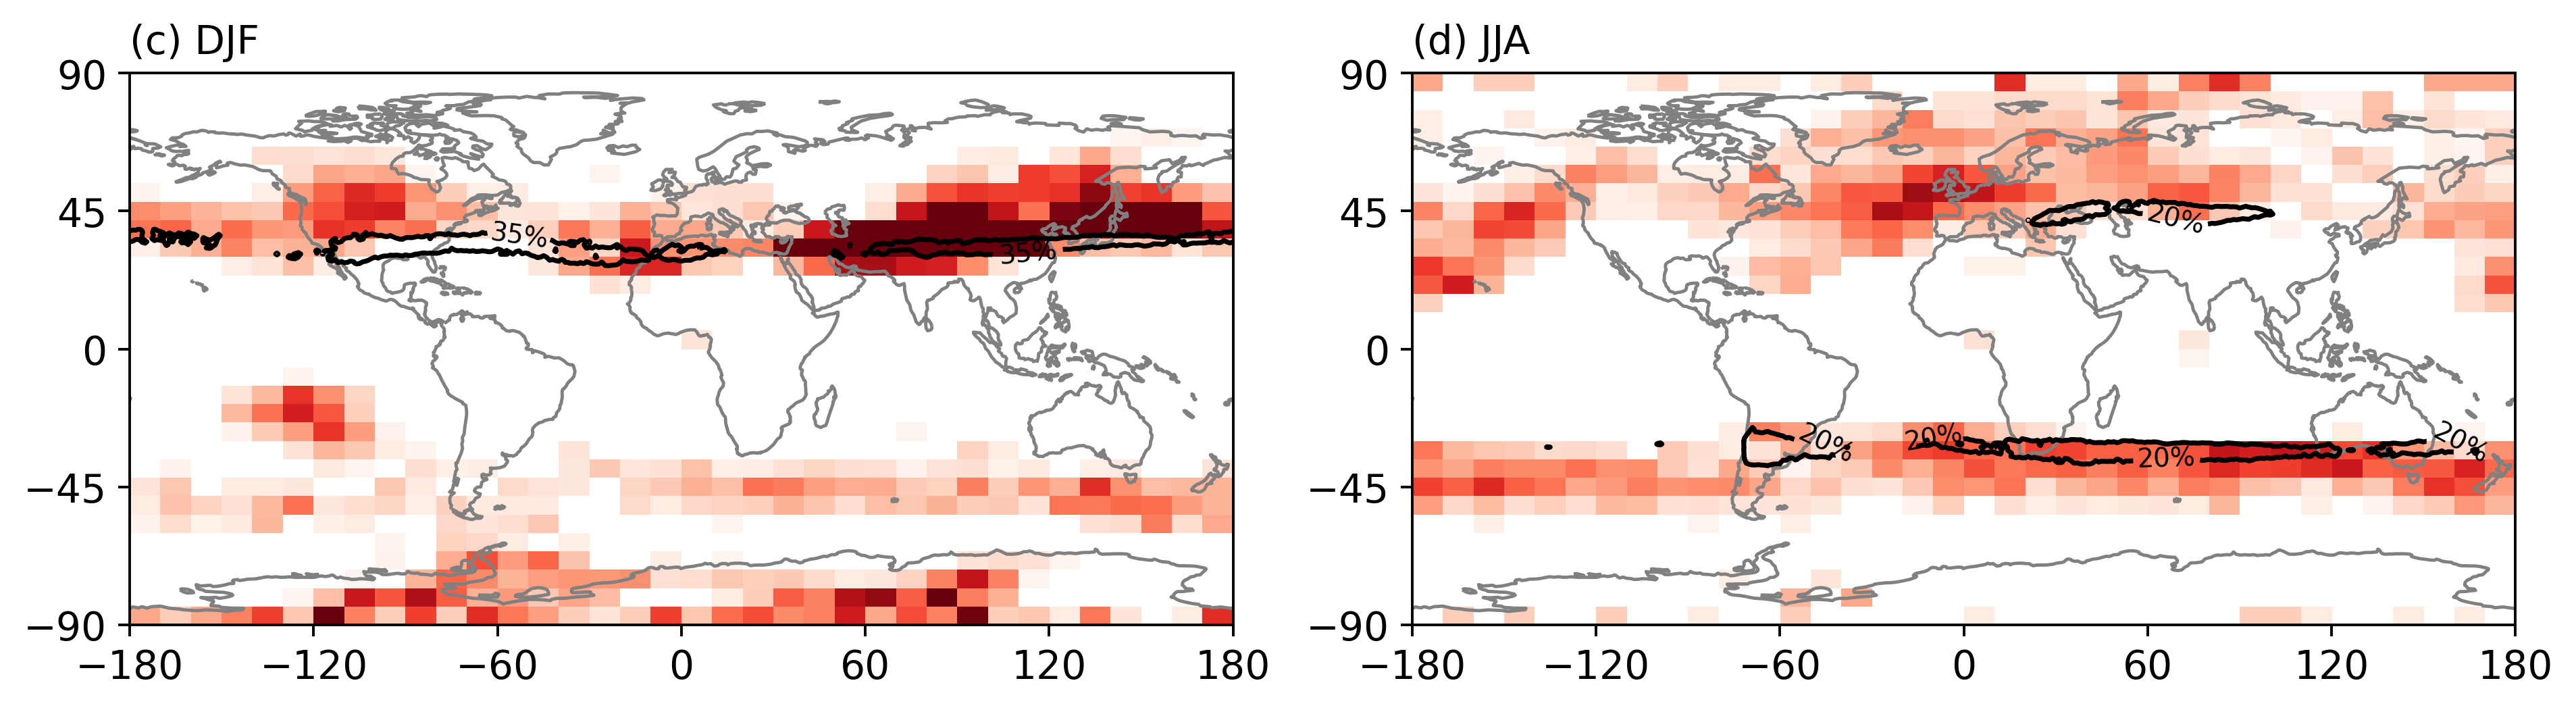

In [54]:
fig = plt.figure(figsize=(11,4), dpi=350)
gs = gridspec.GridSpec(1, 10, figure=fig)
projection = crs.PlateCarree()

extent = [-180 , 180 , 90 , -90]

###
ax1 = fig.add_subplot(gs[0, 0:5], projection=projection)

ax1.set_global()
ax1.set_extent([-180, 180, 90, -90], crs=projection) ## Important
ax1.add_feature(cfeature.COASTLINE, edgecolor="gray")

data_DJF = ( np.mean(Sink_num_5yr[:,:,11:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,0:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,1:-1:12], axis=(2)) )/3 /Grid_area[:,:] # particles per km^2 per month

ax1_pixel = plt.imshow(data_DJF, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap=palette, interpolation='nearest')
# cb1 = plt.colorbar(ax1_pixel, ax=ax1)
# cb1.set_label('[Number of Particles]', fontsize=12);


levels = [35]
ax1_contour = plt.contour(X, Y, DT_freq_DJF, levels=levels, colors='k', linestyles='solid')
ax1.clabel(ax1_contour, inline=True, fmt='%.0f%%', fontsize=8)

ax1.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=projection)

ax1.tick_params(labelsize=12)

# ax1.set_title("DJF", fontsize=11, loc='center');
ax1.set_title("(c) DJF", fontsize=12, loc='left');

print(data.shape)

###
ax3 = fig.add_subplot(gs[0, 5:10], projection=projection)

ax3.set_global()
ax3.set_extent([-180, 180, 90, -90], crs=projection) ## Important
ax3.add_feature(cfeature.COASTLINE, edgecolor="gray")

data_JJA = ( np.mean(Sink_num_5yr[:,:,5:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,6:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,7:-1:12], axis=(2)) )/3 /Grid_area[:,:] # particles per km^2 per month

ax3_pixel = plt.imshow(data_JJA, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap=palette, interpolation='nearest')
# cb3 = plt.colorbar(ax3_pixel, ax=ax3)
# cb3.set_label('[Number of Particles]', fontsize=12);

levels = [20]
ax3_contour = plt.contour(X, Y, DT_freq_JJA, levels=levels, colors='k', linestyles='solid')
ax3.clabel(ax3_contour, inline=True, fmt='%.0f%%', fontsize=8)

ax3.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax3.set_yticks(np.linspace(-90, 90, 5), crs=projection)

ax3.tick_params(labelsize=12)

# ax3.set_title("JJA", fontsize=11, loc='center');
ax3.set_title("(d) JJA", fontsize=12, loc='left');

plt.tight_layout()

print("Copy the colorbar from the above figure!")
plt.savefig("Figure_5c_5d.jpg")

(30, 36)


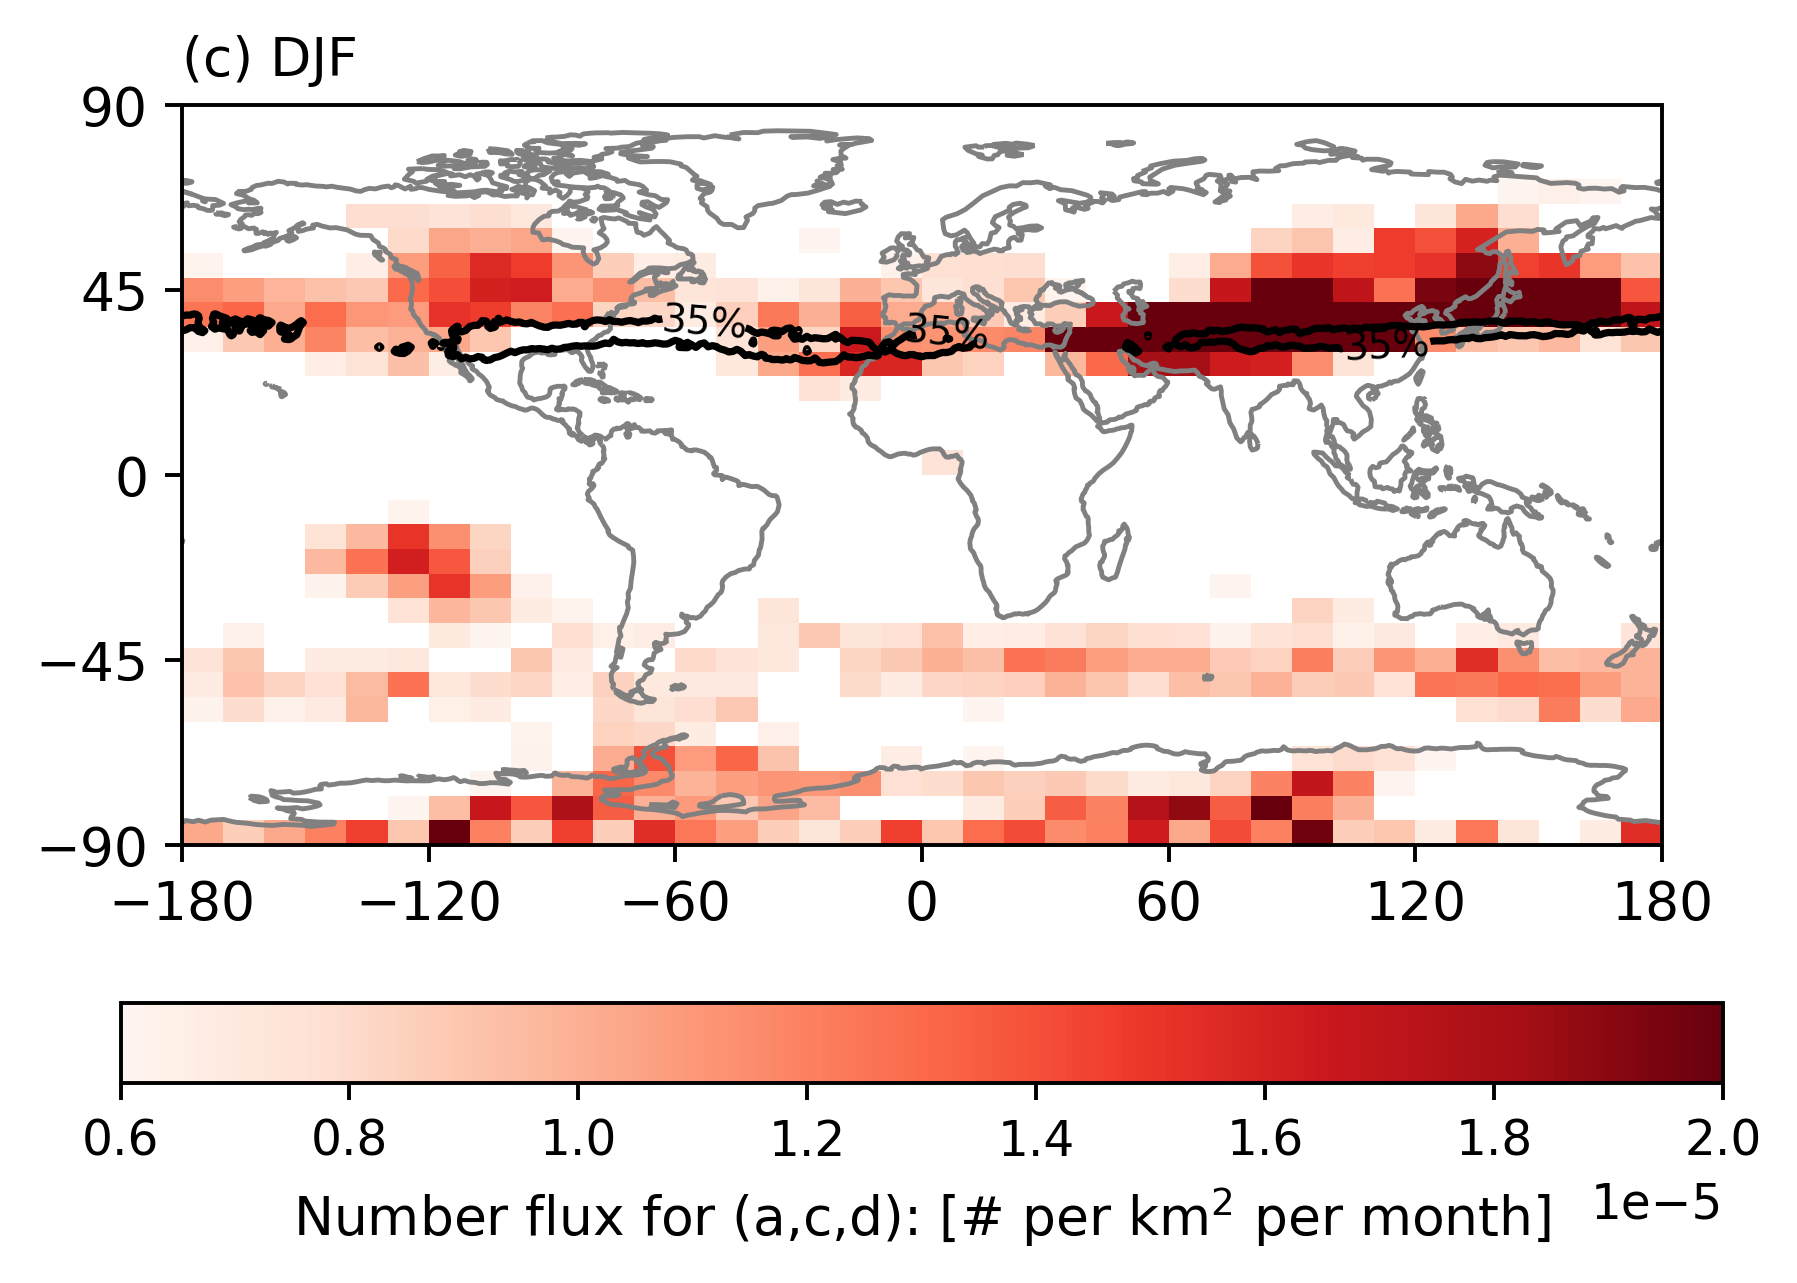

In [56]:
fig = plt.figure(figsize=(13,4), dpi=350)
# gs = gridspec.GridSpec(1, 11, figure=fig)
projection = crs.PlateCarree()

extent = [-180 , 180 , 90 , -90]

###
ax1 = fig.add_subplot(1,2,1, projection=projection)

ax1.set_global()
ax1.set_extent([-180, 180, 90, -90], crs=projection) ## Important
ax1.add_feature(cfeature.COASTLINE, edgecolor="gray")

data_DJF = ( np.mean(Sink_num_5yr[:,:,11:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,0:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,1:-1:12], axis=(2)) )/3 /Grid_area[:,:] # particles per km^2 per month

ax1_pixel = plt.imshow(data_DJF, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap=palette, interpolation='nearest')
cb1 = plt.colorbar(ax1_pixel, ax=ax1, location='bottom')
# cb1.set_label('[Number of Particles]', fontsize=12);
cb1.set_label(f'Number flux for (a,c,d): [# per km$^2$ per month]', fontsize=11);


levels = [35]
ax1_contour = plt.contour(X, Y, DT_freq_DJF, levels=levels, colors='k', linestyles='solid')
ax1.clabel(ax1_contour, inline=True, fmt='%.0f%%', fontsize=8)

ax1.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=projection)

ax1.tick_params(labelsize=11)

# ax1.set_title("DJF", fontsize=11, loc='center');
ax1.set_title("(c) DJF", fontsize=11, loc='left');

print(data.shape)

plt.savefig("Figure_5_colorbar.jpg")

# QBO E-W: downward particle number flux + tropopause foiding frequency

In [37]:
DT_freq.shape

(1826, 181, 361)

In [38]:
###
it_w1 = 365*0
it_w2 = 365*0+5*30

it_w3 = 365*1+6*30
it_w4 = 365*2+5*30

it_w5 = 365*3+7*30
it_w6 = 365*4+9*30

N_mon_W = it_w6-it_w5 + it_w4-it_w3 + it_w2-it_w1

DT_freq_W = ( np.sum(DT_freq[it_w1:it_w2,:,:], axis=0) + np.sum(DT_freq[it_w1:it_w2,:,:], axis=0) + np.sum(DT_freq[it_w1:it_w2,:,:], axis=0) ) / N_mon_W *100

###
it_e1 = 365*0+9*30
it_e2 = 365*1+4*30

it_e3 = 365*2+8*30
it_e4 = 365*3+4*30

N_mon_E = it_e4-it_e3 + it_e2-it_e1

DT_freq_E = ( np.sum(DT_freq[it_e1:it_e2,:,:], axis=0) + np.sum(DT_freq[it_e1:it_e2,:,:], axis=0) ) / N_mon_E *100

DT_freq_E.shape

(181, 361)

(30, 36)


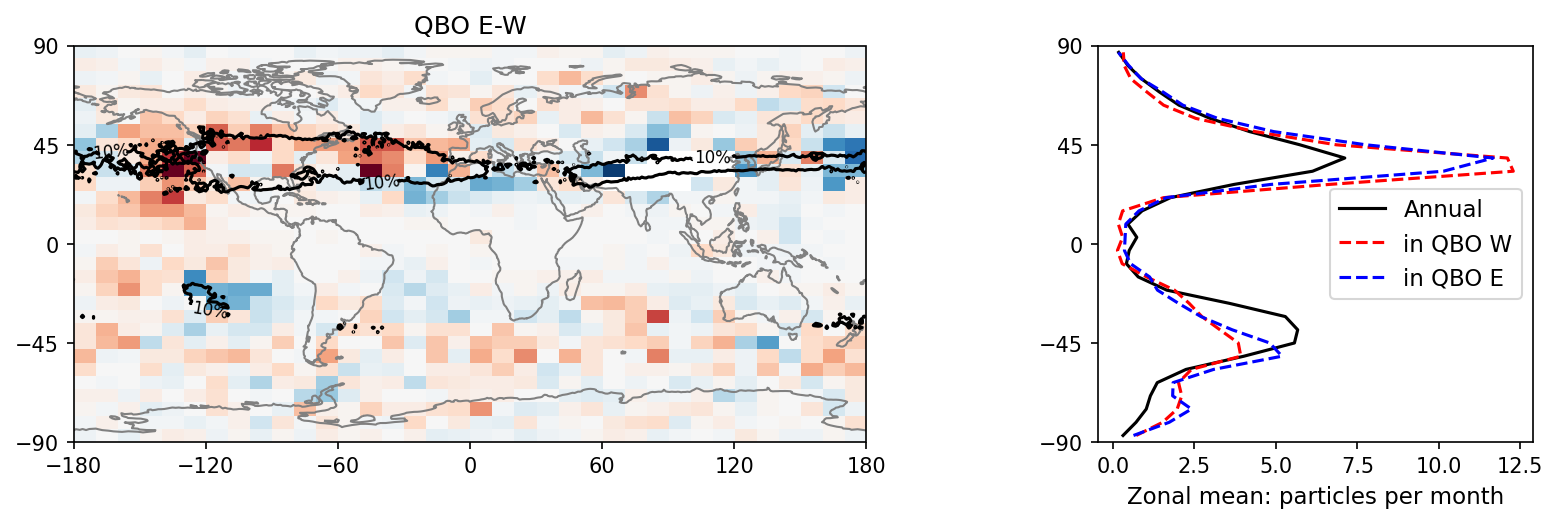

In [39]:
from copy import copy

iz = 2
i_mon1 = 0
i_mon2 = Total_Mon

fig = plt.figure(figsize=(13,3.5), dpi=150)
gs = gridspec.GridSpec(1, 10, figure=fig)
projection = crs.PlateCarree()

Num_min = -10
Num_max = 10
extent = [-180 , 180 , 90 , -90]

###
ax1 = fig.add_subplot(gs[0, 0:6], projection=projection)

ax1.set_global()
ax1.set_extent([-180, 180, 90, -90], crs=projection) ## Important
ax1.add_feature(cfeature.COASTLINE, edgecolor="gray")

palette = copy(plt.get_cmap('RdBu_r'))
palette.set_under('white', 1.0)

data = Sink_num_E - Sink_num_W
ax1_pixel = plt.imshow(data, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap=palette, interpolation='nearest')

# cax = fig.add_axes([0.57, 0.15, 0.01, 0.7])    
# cb1 = plt.colorbar(ax1_pixel, cax=cax, ax=ax1, orientation="vertical")
# # cb1 = plt.colorbar(ax1_pixel, ax=ax1, orientation="horizontal")

levels = [10]
ax1_contour = plt.contour(X, Y, DT_freq_E-DT_freq_W, levels=levels, colors='k', linestyles='solid')
ax1.clabel(ax1_contour, inline=True, fmt='%.0f%%', fontsize=8)

cb1.set_label('Particles per month', fontsize=12);

ax1.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=projection)

ax1.set_title("QBO E-W");

print(data.shape)

###
ax2 = fig.add_subplot(gs[0, 7:10])

data_all = np.mean( Sink_num_5yr[:,:,:], axis=(1,2) )
data_W = np.mean( Sink_num_W[:,:], axis=(1) )
data_E = np.mean( Sink_num_E[:,:], axis=(1) )

ax2.plot(data_all[:], Lats_mid, 'k-',  label="Annual")
ax2.plot(data_W[:], Lats_mid, 'r--', label="in QBO W")
# ax2.plot(data_MAM[:], Lats_mid, 'b--', label="MAM")
ax2.plot(data_E[:], Lats_mid, 'b--', label="in QBO E")
# ax2.plot(data_SON[:], Lats_mid, 'y--', label="SON")

ax2.set_ylim(-90,90)
ax2.set_yticks((-90,-45,0,45,90))
# ax2.set_yticklabels(-90,-45,0,45,90)

ax2.set_xlabel("Zonal mean: particles per month", fontsize=11);
# ax2.set_title("Zonal mean of sinks");

ax2.legend(fontsize=11, loc='center right');
# plt.tight_layout()


In [40]:
# plt.contourf(DT_freq_E-DT_freq_W)
# plt.colorbar()

# 200 hPa wind speed

In [41]:

ds = xr.open_dataset('./U200_2005-2009.nc')

U200 = ds["u"]
y_lat = ds["latitude"]
x_lon = ds["longitude"]

X, Y = np.meshgrid(x_lon, y_lat)

U200_5yr = U200[0:12*5,:,:]

U200_5yr_Mean = np.mean(U200_5yr, axis=0)

a = U200_5yr[1:12*5:12,:,:]

U200_5yr_DJF_mean = ( np.mean(U200_5yr[0:12*5:12,:,:], axis=0) \
                     +np.mean(U200_5yr[1:12*5:12,:,:], axis=0) \
                     +np.mean(U200_5yr[11:12*5:12,:,:], axis=0))/3

U200_5yr_JJA_mean = ( np.mean(U200_5yr[5:12*5:12,:,:], axis=0) \
                     +np.mean(U200_5yr[6:12*5:12,:,:], axis=0) \
                     +np.mean(U200_5yr[7:12*5:12,:,:], axis=0))/3

U200_5yr_JJA_mean.shape

(721, 1440)

In [42]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 60)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2005-01-01 2005-02-01 ... 2009-12-01
Data variables:
    u          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-17 18:21:04 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [43]:
Sink_num_5yr.shape, Grid_area.shape

((30, 36, 60), (30, 36))

# Figure 5

(30, 36)


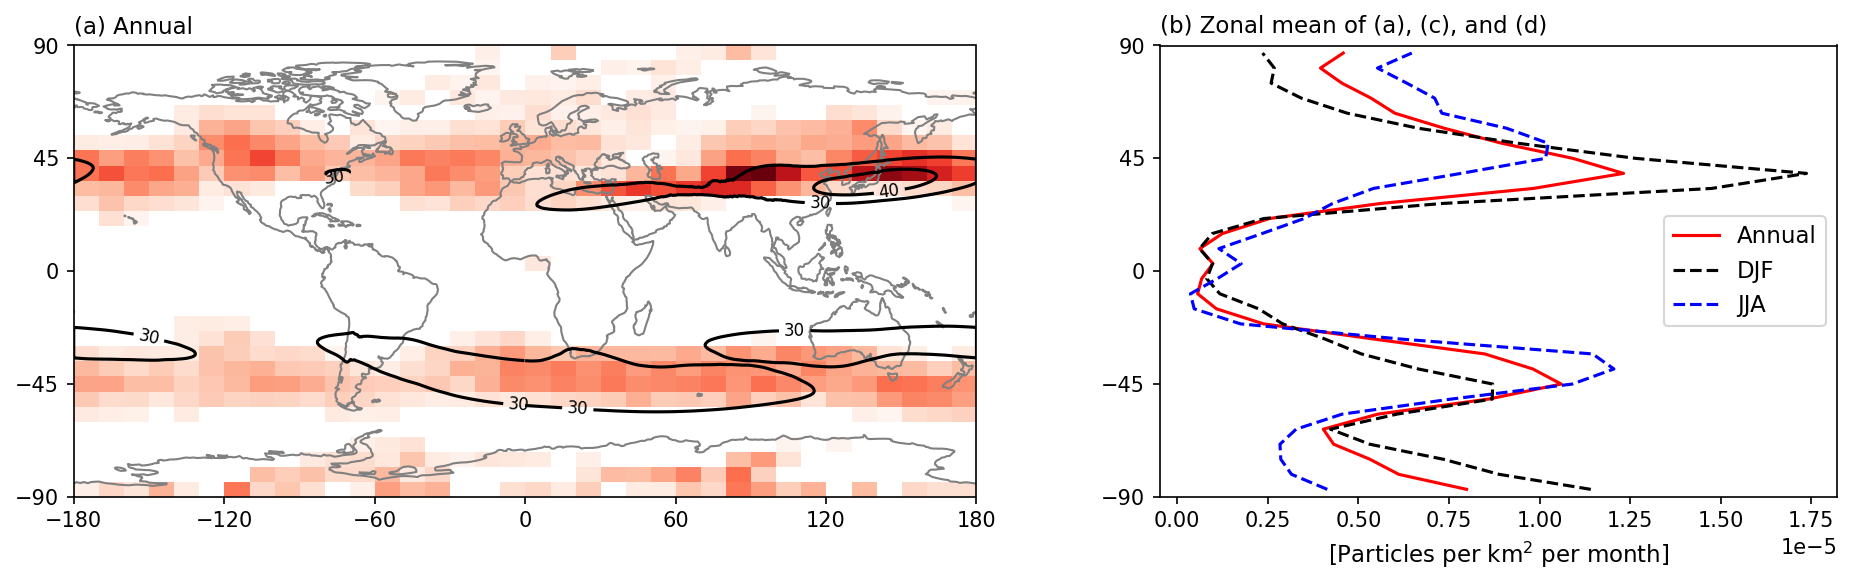

In [44]:

iz = 2
i_mon1 = 0
i_mon2 = Total_Mon

fig = plt.figure(figsize=(13,4), dpi=300)
gs = gridspec.GridSpec(1, 10, figure=fig)
projection = crs.PlateCarree()

Num_min = 6e-6
Num_max = 20e-6
extent = [-180 , 180 , 90 , -90]

###
ax1 = fig.add_subplot(gs[0, 0:6], projection=projection)

ax1.set_global()
ax1.set_extent([-180, 180, 90, -90], crs=projection) ## Important
ax1.add_feature(cfeature.COASTLINE, edgecolor="gray")

palette = copy(plt.get_cmap('Reds'))
palette.set_under('white', 1.0)

data = np.mean( Sink_num_5yr[:,:,:], axis=2 ) / Grid_area[:,:] # particles per km^2 per month
ax1_pixel = plt.imshow(data, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap=palette, interpolation='nearest')


levels = [30,40]
ax1_contour = plt.contour(X, Y, U200_5yr_Mean, levels=levels, colors='k', linestyles='solid')
ax1.clabel(ax1_contour, inline=True, fmt='%.0f', fontsize=8)

# cax = fig.add_axes([0.57, 0.15, 0.01, 0.7])    
# cb1 = plt.colorbar(ax1_pixel, cax=cax, ax=ax1, orientation="vertical")
## cb1 = plt.colorbar(ax1_pixel, ax=ax1, orientation="horizontal")
# cb1.set_label('Particles flux', fontsize=11);

ax1.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=projection)

ax1.set_title("(a) Annual", loc='left', fontsize=11);
# ax1.set_title("Annual", loc='center', fontsize=11);

print(data.shape)


###
ax2 = fig.add_subplot(gs[0, 6:10])

data_all = np.mean( Sink_num_5yr[:,:,:], axis=(1,2) ) 

data_DJF = ( np.mean(Sink_num_5yr[:,:,11:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,0:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,1:-1:12], axis=(1,2)) )/3 

data_MAM = ( np.mean(Sink_num_5yr[:,:,2:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,3:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,4:-1:12], axis=(1,2)) )/3 

data_JJA = ( np.mean(Sink_num_5yr[:,:,5:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,6:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,7:-1:12], axis=(1,2)) )/3 

data_SON = ( np.mean(Sink_num_5yr[:,:,8:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,9:-1:12], axis=(1,2))
            +np.mean(Sink_num_5yr[:,:,10:-1:12], axis=(1,2)) )/3



ax2.plot(data_all[:]/ Grid_area[:,0], Lats_mid, 'r-',  label="Annual")
ax2.plot(data_DJF[:]/ Grid_area[:,0], Lats_mid, 'k--', label="DJF")
# ax2.plot(data_MAM[:], Lats_mid, 'b--', label="MAM")
ax2.plot(data_JJA[:]/ Grid_area[:,0], Lats_mid, 'b--', label="JJA")
# ax2.plot(data_SON[:], Lats_mid, 'y--', label="SON")

ax2.set_ylim(-90,90)
ax2.set_yticks((-90,-45,0,45,90))
# ax2.set_yticklabels(-90,-45,0,45,90)

ax2.set_xlabel(f"[Particles per km$^2$ per month]", fontsize=11);
ax2.set_title("(b) Zonal mean of (a), (c), and (d)", loc='left', fontsize=11);

ax2.legend(fontsize=11, loc='center right');
plt.tight_layout()


(30, 36)
Copy the colorbar from the above figure!


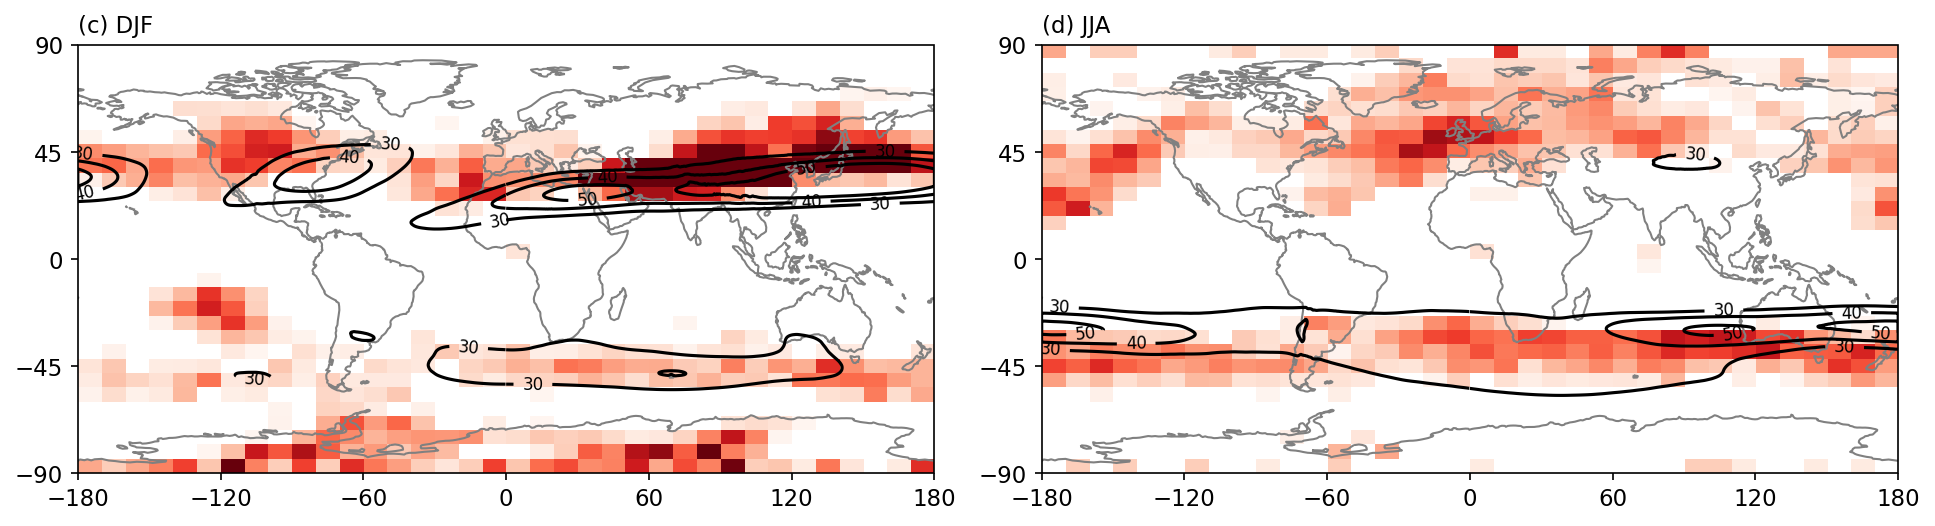

In [45]:

fig = plt.figure(figsize=(13,4), dpi=300)
gs = gridspec.GridSpec(1, 11, figure=fig)
projection = crs.PlateCarree()

extent = [-180 , 180 , 90 , -90]

###
ax1 = fig.add_subplot(1,2,1, projection=projection)

ax1.set_global()
ax1.set_extent([-180, 180, 90, -90], crs=projection) ## Important
ax1.add_feature(cfeature.COASTLINE, edgecolor="gray")

data_DJF = ( np.mean(Sink_num_5yr[:,:,11:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,0:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,1:-1:12], axis=(2)) )/3 /Grid_area[:,:] # particles per km^2 per month

ax1_pixel = plt.imshow(data_DJF, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap=palette, interpolation='nearest')
# cb1 = plt.colorbar(ax1_pixel, ax=ax1)
# cb1.set_label('[Number of Particles]', fontsize=12);


levels = [30,40,50]
ax1_contour = plt.contour(X, Y, U200_5yr_DJF_mean, levels=levels, colors='k', linestyles='solid')
ax1.clabel(ax1_contour, inline=True, fmt='%.0f', fontsize=8)

ax1.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=projection)

ax1.tick_params(labelsize=11)

# ax1.set_title("DJF", fontsize=11, loc='center');
ax1.set_title("(c) DJF", fontsize=11, loc='left');

print(data.shape)


###
ax3 = fig.add_subplot(1,2,2, projection=projection)

ax3.set_global()
ax3.set_extent([-180, 180, 90, -90], crs=projection) ## Important
ax3.add_feature(cfeature.COASTLINE, edgecolor="gray")

data_JJA = ( np.mean(Sink_num_5yr[:,:,5:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,6:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,7:-1:12], axis=(2)) )/3 /Grid_area[:,:] # particles per km^2 per month

ax3_pixel = plt.imshow(data_JJA, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap=palette, interpolation='nearest')
# cb3 = plt.colorbar(ax3_pixel, ax=ax3)
# cb3.set_label('[Number of Particles]', fontsize=12);

levels = [30,40,50]
ax3_contour = plt.contour(X, Y, U200_5yr_JJA_mean, levels=levels, colors='k', linestyles='solid')
ax3.clabel(ax3_contour, inline=True, fmt='%.0f', fontsize=8)

ax3.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax3.set_yticks(np.linspace(-90, 90, 5), crs=projection)

ax3.tick_params(labelsize=11)

# ax3.set_title("JJA", fontsize=11, loc='center');
ax3.set_title("(d) JJA", fontsize=11, loc='left');

plt.tight_layout()

print("Copy the colorbar from the above figure!")


(30, 36)


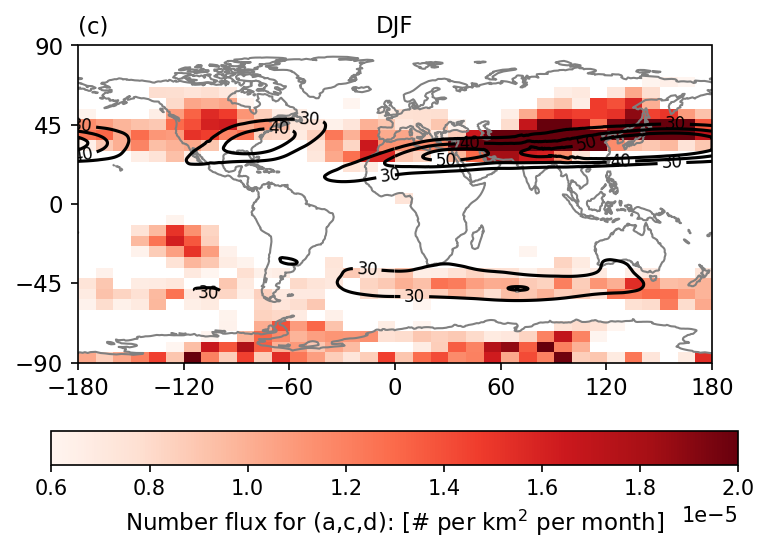

In [46]:

fig = plt.figure(figsize=(13,4), dpi=300)
gs = gridspec.GridSpec(1, 11, figure=fig)
projection = crs.PlateCarree()


extent = [-180 , 180 , 90 , -90]

###
ax1 = fig.add_subplot(1,2,1, projection=projection)

ax1.set_global()
ax1.set_extent([-180, 180, 90, -90], crs=projection) ## Important
ax1.add_feature(cfeature.COASTLINE, edgecolor="gray")

data_DJF = ( np.mean(Sink_num_5yr[:,:,11:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,0:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,1:-1:12], axis=(2)) )/3 /Grid_area[:,:] # particles per km^2 per month

ax1_pixel = plt.imshow(data_DJF, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap=palette, interpolation='nearest')

cb1 = plt.colorbar(ax1_pixel, ax=ax1, orientation="horizontal")
cb1.set_label(f'Number flux for (a,c,d): [# per km$^2$ per month]', fontsize=11);


levels = [30,40,50]
ax1_contour = plt.contour(X, Y, U200_5yr_DJF_mean, levels=levels, colors='k', linestyles='solid')
ax1.clabel(ax1_contour, inline=True, fmt='%.0f', fontsize=8)



ax1.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=projection)

ax1.tick_params(labelsize=11)

ax1.set_title("DJF", fontsize=11, loc='center');
ax1.set_title("(c)", fontsize=11, loc='left');

print(data.shape)

# Cluster analysis for different QBO phases

(30, 36)
Copy the colorbar from the above figure!


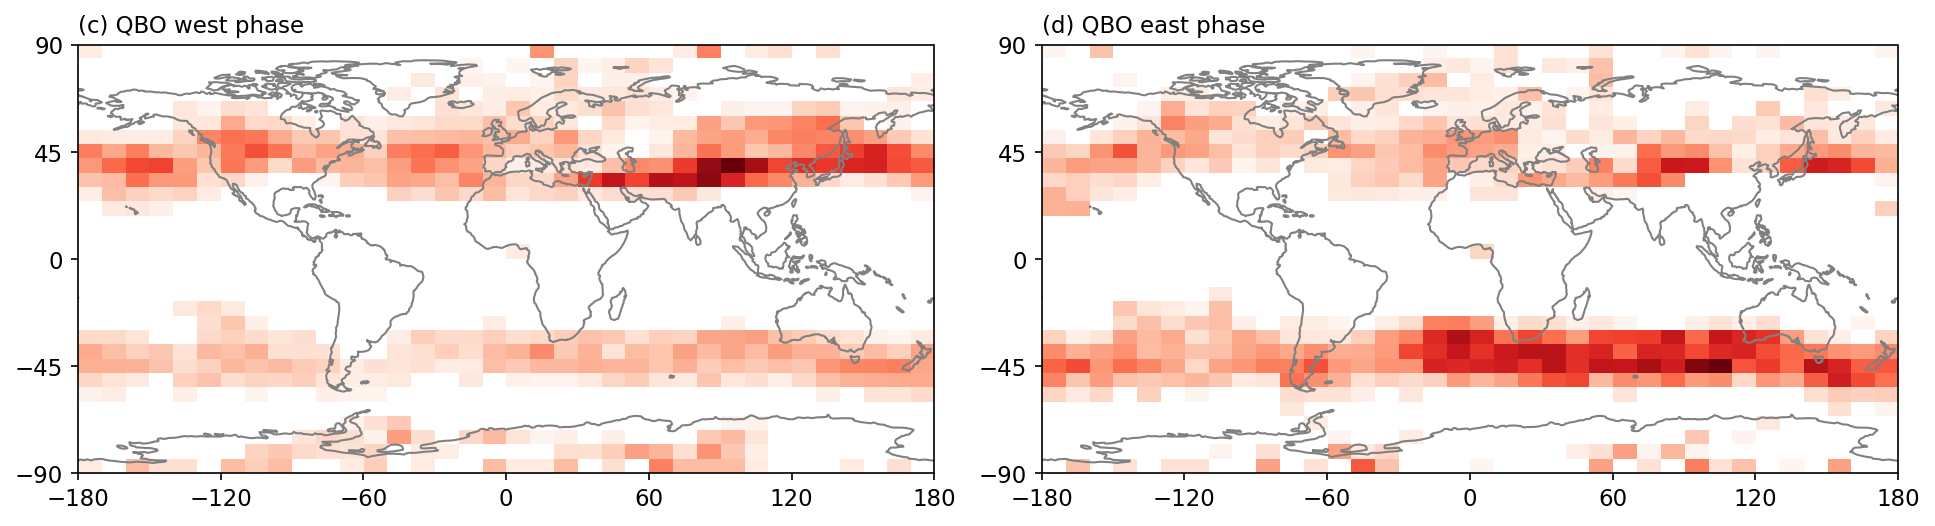

In [47]:
fig = plt.figure(figsize=(13,4), dpi=150)
gs = gridspec.GridSpec(1, 11, figure=fig)
projection = crs.PlateCarree()

extent = [-180 , 180 , 90 , -90]

# plt.plot(month[res11], data2[res11], 'bD')
# plt.plot(month[res22], data2[res22], 'b*')

###
ax1 = fig.add_subplot(1,2,1, projection=projection)

ax1.set_global()
ax1.set_extent([-180, 180, 90, -90], crs=projection) ## Important
ax1.add_feature(cfeature.COASTLINE, edgecolor="gray")

data_DJF = np.mean(Sink_num_5yr[:,:,res11], axis=(2)) / Grid_area[:,:] # particles per km^2 per month

ax1_pixel = plt.imshow(data_DJF, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap=palette, interpolation='nearest')
# cb1 = plt.colorbar(ax1_pixel, ax=ax1)
# cb1.set_label('[Number of Particles]', fontsize=12);


# levels = [30,40,50]
# ax1_contour = plt.contour(X, Y, U200_5yr_DJF_mean, levels=levels, colors='k', linestyles='solid')
# ax1.clabel(ax1_contour, inline=True, fmt='%.0f', fontsize=8)

ax1.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=projection)

ax1.tick_params(labelsize=11)

# ax1.set_title("DJF", fontsize=11, loc='center');
ax1.set_title("(c) QBO west phase", fontsize=11, loc='left');

print(data.shape)


###
ax3 = fig.add_subplot(1,2,2, projection=projection)

ax3.set_global()
ax3.set_extent([-180, 180, 90, -90], crs=projection) ## Important
ax3.add_feature(cfeature.COASTLINE, edgecolor="gray")

data_JJA = np.mean(Sink_num_5yr[:,:,res22], axis=(2)) / Grid_area[:,:] # particles per km^2 per month

ax3_pixel = plt.imshow(data_JJA, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap=palette, interpolation='nearest')
# cb3 = plt.colorbar(ax3_pixel, ax=ax3)
# cb3.set_label('[Number of Particles]', fontsize=12);

# levels = [30,40,50]
# ax3_contour = plt.contour(X, Y, U200_5yr_JJA_mean, levels=levels, colors='k', linestyles='solid')
# ax3.clabel(ax3_contour, inline=True, fmt='%.0f', fontsize=8)

ax3.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax3.set_yticks(np.linspace(-90, 90, 5), crs=projection)

ax3.tick_params(labelsize=11)

# ax3.set_title("JJA", fontsize=11, loc='center');
ax3.set_title("(d) QBO east phase", fontsize=11, loc='left');

plt.tight_layout()

print("Copy the colorbar from the above figure!")

# Stop here

(30, 36)


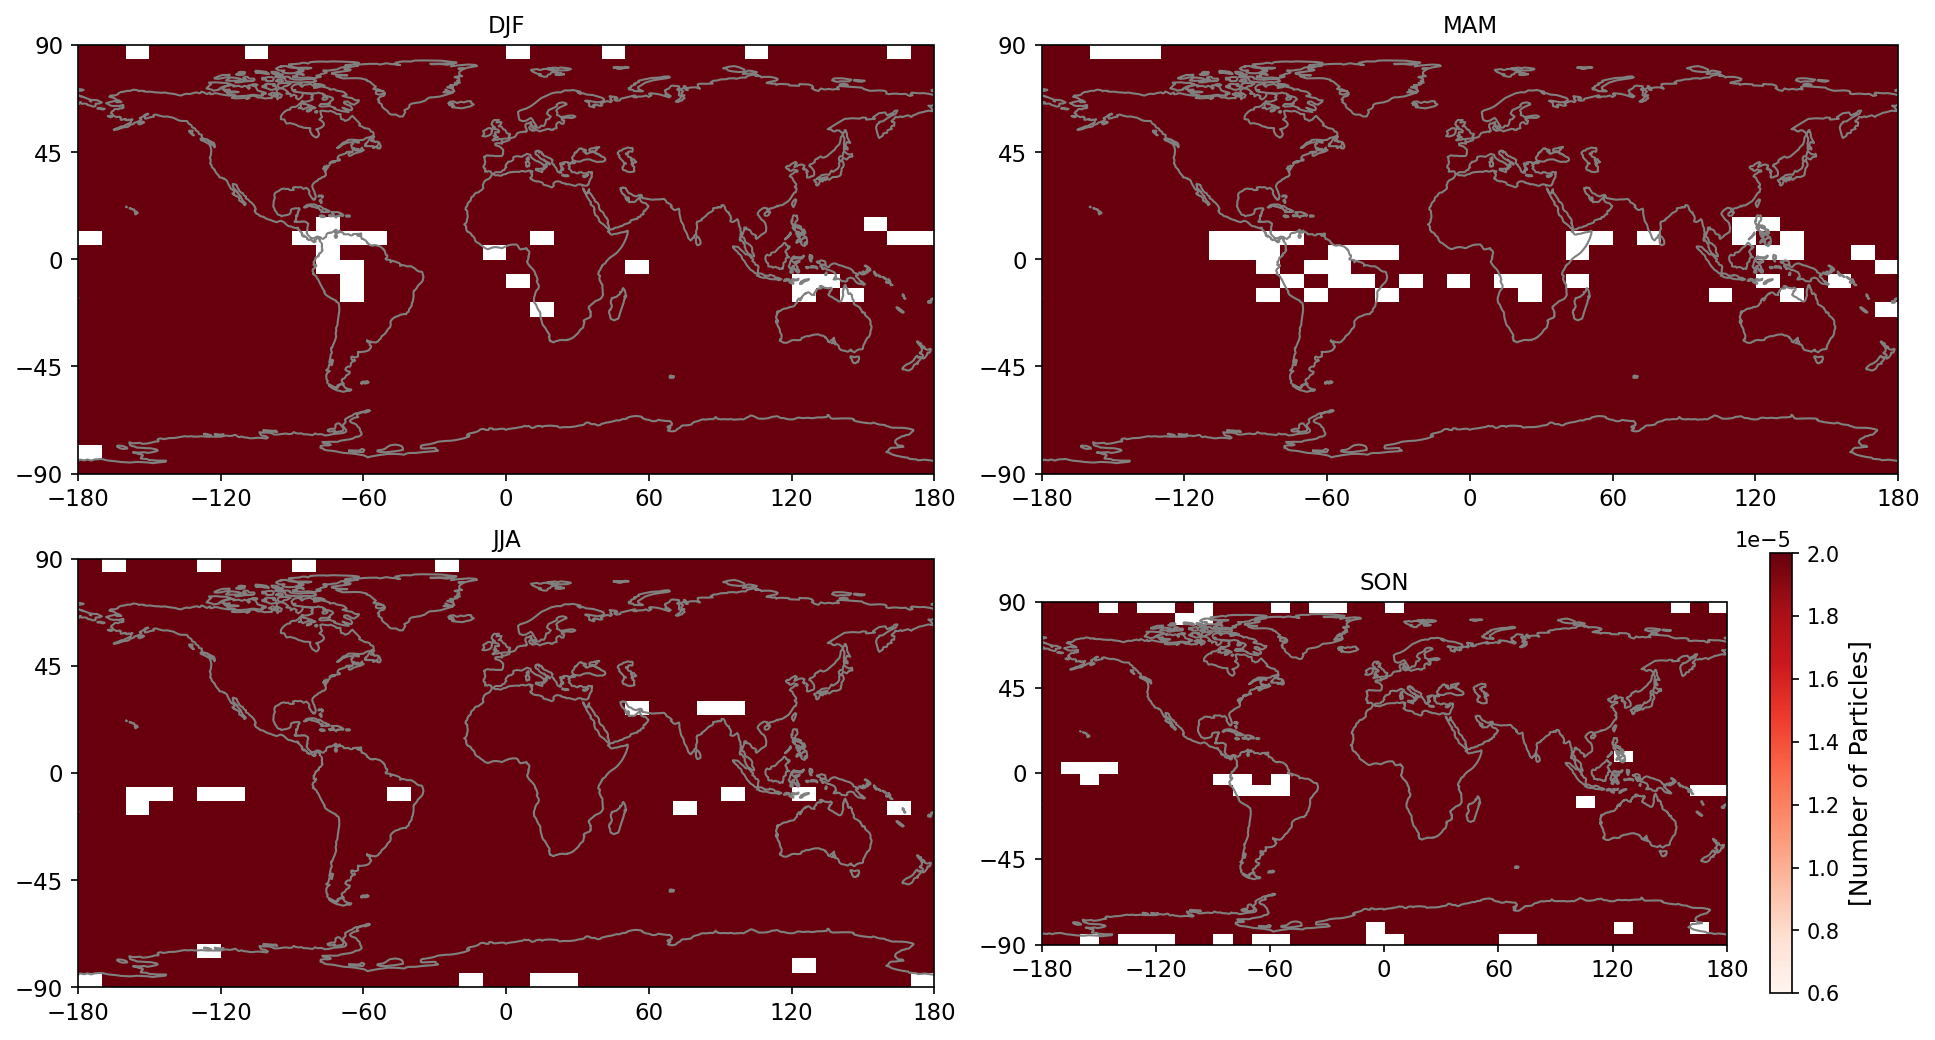

In [34]:
fig = plt.figure(figsize=(13,7), dpi=150)
gs = gridspec.GridSpec(1, 11, figure=fig)
projection = crs.PlateCarree()


extent = [-180 , 180 , 90 , -90]

###
ax1 = fig.add_subplot(2,2,1, projection=projection)

ax1.set_global()
ax1.set_extent([-180, 180, 90, -90], crs=projection) ## Important
ax1.add_feature(cfeature.COASTLINE, edgecolor="gray")

data_DJF = ( np.mean(Sink_num_5yr[:,:,11:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,0:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,1:-1:12], axis=(2)) )/3

ax1_pixel = plt.imshow(data_DJF, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap=palette, interpolation='nearest')

# cb1 = plt.colorbar(ax1_pixel, ax=ax1)
# cb1.set_label('[Number of Particles]', fontsize=12);

ax1.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=projection)

ax1.tick_params(labelsize=11)

ax1.set_title("DJF", fontsize=11);

print(data.shape)


###
ax2 = fig.add_subplot(2,2,2, projection=projection)

ax2.set_global()
ax2.set_extent([-180, 180, 90, -90], crs=projection) ## Important
ax2.add_feature(cfeature.COASTLINE, edgecolor="gray")

data_MAM = ( np.mean(Sink_num_5yr[:,:,2:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,3:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,4:-1:12], axis=(2)) )/3

ax2_pixel = plt.imshow(data_MAM, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap=palette, interpolation='nearest')

# cb2 = plt.colorbar(ax2_pixel, ax=ax2)
# cb2.set_label('[Number of Particles]', fontsize=12);

ax2.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax2.set_yticks(np.linspace(-90, 90, 5), crs=projection)

ax2.tick_params(labelsize=11)

ax2.set_title("MAM", fontsize=11);


###
ax3 = fig.add_subplot(2,2,3, projection=projection)

ax3.set_global()
ax3.set_extent([-180, 180, 90, -90], crs=projection) ## Important
ax3.add_feature(cfeature.COASTLINE, edgecolor="gray")

data_JJA = ( np.mean(Sink_num_5yr[:,:,5:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,6:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,7:-1:12], axis=(2)) )/3

ax3_pixel = plt.imshow(data_JJA, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap=palette, interpolation='nearest')

# cb3 = plt.colorbar(ax3_pixel, ax=ax3)
# cb3.set_label('[Number of Particles]', fontsize=12);

ax3.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax3.set_yticks(np.linspace(-90, 90, 5), crs=projection)

ax3.tick_params(labelsize=11)

ax3.set_title("JJA", fontsize=11);



###
ax4 = fig.add_subplot(2,2,4, projection=projection)

ax4.set_global()
ax4.set_extent([-180, 180, 90, -90], crs=projection) ## Important
ax4.add_feature(cfeature.COASTLINE, edgecolor="gray")

data_SON = ( np.mean(Sink_num_5yr[:,:,8:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,9:-1:12], axis=(2))
            +np.mean(Sink_num_5yr[:,:,10:-1:12], axis=(2)) )/3

ax4_pixel = plt.imshow(data_SON, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap=palette, interpolation='nearest')

cb4 = plt.colorbar(ax4_pixel, ax=ax4)
cb4.set_label('[Number of Particles]', fontsize=12);

ax4.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax4.set_yticks(np.linspace(-90, 90, 5), crs=projection)

ax4.tick_params(labelsize=11)

ax4.set_title("SON", fontsize=11);

plt.tight_layout()



In [35]:
np.sum(Sink_num, axis=(0,1,2,3))/10/12/10/6/24


1.8333333333333333

In [21]:
Sink_num.shape

(30, 36, 7, 240)

(30, 36)


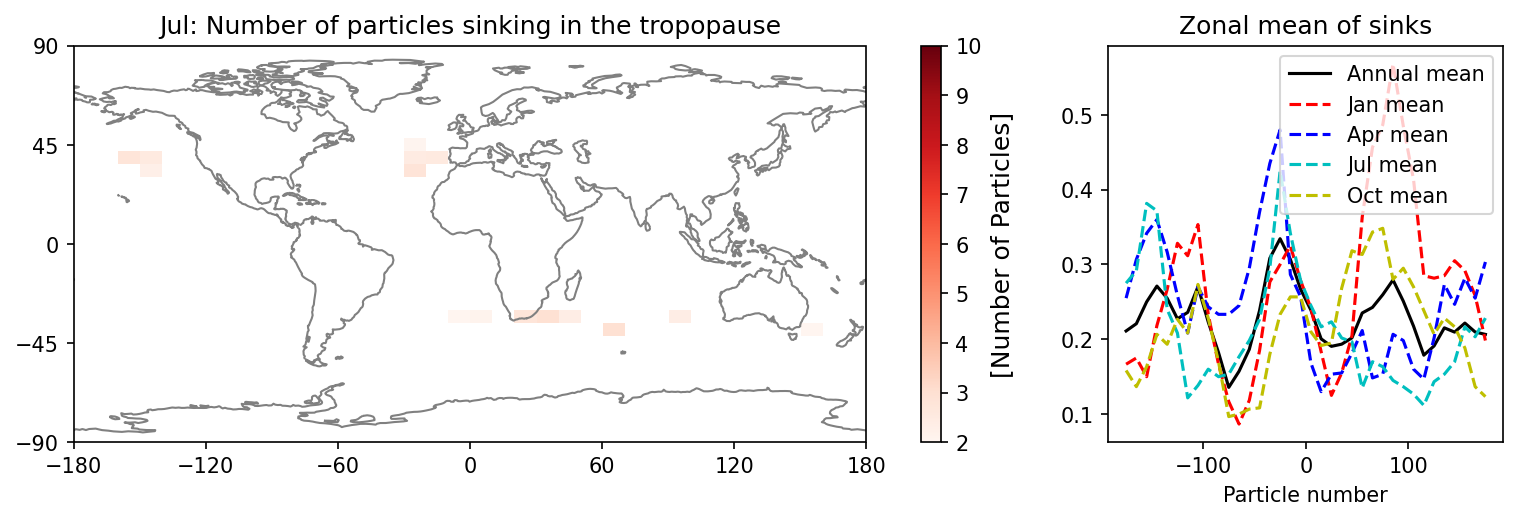

In [22]:
fig = plt.figure(figsize=(13,3.5), dpi=150)
gs = gridspec.GridSpec(1, 11, figure=fig)
projection = crs.PlateCarree()


extent = [-180 , 180 , 90 , -90]

###
ax1 = fig.add_subplot(gs[0, 0:8], projection=projection)

ax1.set_global()
ax1.set_extent([-180, 180, 90, -90], crs=projection) ## Important
ax1.add_feature(cfeature.COASTLINE, edgecolor="gray")

data = np.mean( Sink_num[:,:,iz,i_mon1+6:i_mon2:12], axis=2 )
ax1_pixel = plt.imshow(data, vmin=Num_min, vmax=Num_max,\
           extent = extent, cmap=palette, interpolation='nearest')

cb1 = plt.colorbar(ax1_pixel, ax=ax1)
cb1.set_label('[Number of Particles]', fontsize=12);

ax1.set_xticks(np.linspace(-180, 180, 7), crs=projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=projection)

ax1.set_title("Jul: Number of particles sinking in the tropopause");

print(data.shape)


###
ax2 = fig.add_subplot(gs[0, 8:11])

data_all = np.mean( Sink_num[:,:,iz,i_mon1:i_mon2], axis=(0,2) )
data_Jan = np.mean( Sink_num[:,:,iz,i_mon1:i_mon2:12], axis=(0,2))
data_Apr = np.mean( Sink_num[:,:,iz,i_mon1+3:i_mon2:12], axis=(0,2))
data_Jul = np.mean( Sink_num[:,:,iz,i_mon1+6:i_mon2:12], axis=(0,2))
data_Oct = np.mean( Sink_num[:,:,iz,i_mon1+9:i_mon2:12], axis=(0,2))

ax2.plot(Lons_mid, data_all[:],  'k-', label="Annual mean")
ax2.plot(Lons_mid, data_Jan[:], 'r--', label="Jan mean")
ax2.plot(Lons_mid, data_Apr[:], 'b--', label="Apr mean")
ax2.plot(Lons_mid, data_Jul[:], 'c--', label="Jul mean")
ax2.plot(Lons_mid, data_Oct[:], 'y--', label="Oct mean")

# ax2.set_ylim(-90,90)
# ax2.set_yticks((-90,-45,0,45,90))
# ax2.set_yticklabels(-90,-45,0,45,90)

ax2.set_xlabel("Particle number");
ax2.set_title("Zonal mean of sinks");

ax2.legend();